# COGS 188 - Final Project

# Killer Sudoku Discussion: Comparative Analysis among 5 different algorithms

## Group members

- Zirui Lin
- Yanxiong Chen
- Jiawei Lyu

In [ ]:
import pandas as pd
from IPython.display import Image
import numpy as np
import random
import ast
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import time
import itertools
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Activation, Conv2D, BatchNormalization, Dense, Flatten, Reshape
from keras.models import Sequential
import copy
from tqdm import tqdm
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam


# Project Description:
This project aims to design an AI agent that is capable of solving the killer Sudoku puzzle. Killer Sudoku demands logical deduction skills, while killer Sudoku solvers exist, this project seeks to solve the puzzle using more advanced problem-solving strategies and algorithms, as well as machine learning techniques to improve the solving efficiency.

### Killer Sudoku (https://en.wikipedia.org/wiki/Killer_sudoku)
Killer Sudoku is a puzzle that combines the elements of Sudoku and Kakuro. The game is designed in the following way: the puzzle is 9 by 9 grid consisting of 81 cells. At the begining, the puzzle is empty with cages.

The player's goal is to fill the grid with number 1 to 9 based on the following rule: each row, column, nonet (a 3x3 grid of cells, also called a box) contains each number exactly once. In addition, the killer sudoku should follow an additional constraint: the sum of all cells in each cage should add up to the specified cage sum.

### Significance
The formulation of Killer Sudoku as a Constraint Satisfaction Problem (CSP) has significant implications for the development of computational methods to solve logical puzzles and their applications. Here is a concise explanation of the importance of this problem and its potential extensions:

**Algorithm Testing and Development:** The additional constraints in Killer Sudoku provide a more complex challenge than standard Sudoku, making it an excellent benchmark for testing and developing advanced algorithms, including Artificial Intelligence and Machine Learning.

**Extensions and Broader Uses:** \\
1. **Software Testing:** Algorithms designed to solve CSPs can be applied in software testing, particularly in the generation of test cases where managing multiple conditions and constraints is required.
2. **Artificial Intelligence:** Solving games like Killer Sudoku can enhance the problem-solving capabilities and decision-making of AI systems, laying the foundation for AI applications in more complex real-world scenarios.
3. **Optimization Problems in Engineering:** The techniques used in solving Killer Sudoku can be applied to a variety of optimization problems in engineering, such as load balancing in network systems and layout optimization in manufacturing.

Through these applications, Killer Sudoku not only serves as an intriguing intellectual challenge but also as an effective tool for solving complex problems. The techniques and strategies used can be widely applied across various fields.

# Abstract
The goal of this project is to develop an artificial intelligence agent that can solve Killer Sudoku puzzles from a dataset containing twelve thousand Killer Sudoku puzzles. Each puzzle in the dataset is represented by a row of 81 digits, capturing additional data from the Killer Sudoku grid as well as cage sums. We will use this data to train our RL and DL models and test our four RL or DL AI agents. The performance of the AI will be measured by its accuracy (percentage of puzzles solved correctly). We will do a comparative analysis on 5 different methods: Dynamic Programming, DP with Backtracking, SARSA, CNN, Monte Carlo, and trying to figure out why they perform such results.

# Background

The exploration of solutions to Sudoku, a popular logic game, has been a hot topic in computer science and mathematics research.Logically, Sudoku problems are essentially NP-complete problems, not to mention its variant, Killer Sudoku. <a name="killer"></a>[<sup>[1]</sup>](#killernote) This means that no single algorithm can solve all Killer Sudoku instances most efficiently.Therefore, the choice of algorithms for solving Sudoku problems has become an important research direction, aiming at selecting the best solution from existing efficient algorithms, rather than redeveloping algorithms for each puzzle.<a name="thesis"></a>[<sup>[2]</sup>](#thesisnote).

In recent years we can see numerous discussions of the sudoku problem appearing in the field of machine learning and programming, such as a new hybrid algorithm developed by a researcher that combines a variety of algorithms with all-different, a global constraint in constraint programming. The algorithm utilizes a forbidden search procedure to efficiently combine with all-different constraints, for efficient domain filtering of constraints that must be pairwise different <a name="soto"></a>[<sup>[3]</sup>](#sotonote).

In this project, our group will also focus on using deep learning, reinforcement learning, or other unsupervised models (we haven't quite decided in detail yet) to try to explore the Killer Sudoku problem in our own way.


# Problem Statement

This problem can be formulated as a Constraint Satisfication Problem: \\
**Set of variables**: \\
Let $X_{i,j}$ denotes the cell on the i-th row and j-th column of the 9 by 9 game board. Then there will be a set of 81 variables: $\{X_{1,1}, X_{1, 2}, ..., X_{2, 1}, ..., X_{9,9}\}$. \\
**Set of domains for each variable**: \\
Set of domains $D_{i,j} = \{1, 2, 3, 4, 5, 6, 7, 8, 9\}$. \\
**Set of constraints that specify allowable combinations of values:** \\
1. Any row in the grid contains all of the number from 1 - 9:  for any row $i \in [1, 9]$, Alldiff($X_{i, 1}, X_{i, 2}, ..., X_{i, 9}$), and $X_{i,j} \in \{1, 2, 3, ..., 9\}$. \\

2. Any column in the grid contains all of the number from 1 - 9: for any column $j \in [1, 9]$, Alldiff($X_{1, j}, X_{2, j}, ..., X_{9, j}$), and $X_{i,j} \in \{1, 2, 3, ..., 9\}$. \\

3. Each 3 by 3 subgrid (a total of 9 of such subgrids) in the game board must contain all of the digits from 1 - 9: \\ The following sets must contain all digits from 1 - 9 with no duplicates: \\
$$
\begin{Bmatrix}X_{1, 1}, X_{1, 2}, X_{1, 3} \\
X_{2, 1}, X_{2, 2}, X_{2, 3} \\
X_{3, 1}, X_{3, 2}, X_{3, 3} \end{Bmatrix},  ..., \\
\begin{Bmatrix}X_{6, 7}, X_{6, 8}, X_{6, 9} \\
X_{7, 7}, X_{7, 8}, X_{7, 9} \\
X_{9, 7}, X_{9, 8}, X_{9, 9} \end{Bmatrix}
$$

**Additional Constraints for Killer Sudoku:** \\

4. **Cage Sum Constraint:** Each cage (group of one or more cells which forms part of a larger nonet or between nonets) has a defined sum. The cells within each cage must sum to a specific value. If cage
$k$ includes cells $\{(i_1, j_1), (i_2, j_2), ..., (i_n, j_n)\}$ and has a sum $S_k$, then:
$$X_{i_1,j_1} + X_{i_2,j_2} + ... + X_{i_n,j_n} = S_k$$

5. **Cage Uniqueness Constraint:** Each cell within a cage must contain a unique number, that is, no numbers within a cage can repeat. This can be formulated using the Alldiff constraint for the variables within each cage:
$$Alldiff(X_{i_1,j_1},X_{i_2,j_2},...,X_{i_n,j_n})$$

This CSP formulation for Killer Sudoku thus combines the structural constraints of traditional Sudoku with the added complexity of cages, each with its own sum and internal uniqueness constraint, adding a layer of challenge and complexity to the puzzle.



# Data

### Data Link: https://github.com/UvA-KR16/KilerSudoku/tree/master/data

*Although we used their data, all the data we used to train our models are pre-processed by us.*

The dataset contains two types of files:
1. **Puzzle(.killer file)**.
   - **Description**: A file contains n lines of strings, each of which represents a cage. e.g., 11=(0, 5),6+(0, 4),5. where 11 is the sum of this cage, (0,5) and (0,4) are the cells that make up the cage, and 6 and 5 are the numbers that fill in (0,5) and (0,4), respectively.
   - **Format**: n lines of string with format $sum = (x_1,y_1),number_1 + (x_2,y_2),number_2 + ... + (x_n,y_n),number_n$

2. **Solution(.ans file)**
   - **Description**: A file with 9 lines of string, each line has 9 numbers that combine to form a 9*9 sudoku solution. e.g. \\
[1, 2, 3, 4, 5, 6, 7, 8, 9] \\
[5, 7, 8, 1, 3, 9, 6, 2, 4] \\
[4, 9, 6, 8, 7, 2, 1, 5, 3] \\
[9, 5, 2, 3, 8, 1, 4, 6, 7] \\
[6, 4, 1, 2, 9, 7, 8, 3, 5] \\
[3, 8, 7, 5, 6, 4, 2, 9, 1] \\
[7, 1, 9, 6, 2, 3, 5, 4, 8] \\
[8, 6, 4, 9, 1, 5, 3, 7, 2] \\
[2, 3, 5, 7, 4, 8, 9, 1, 6] \\
   - **Format**:  9 lines of string, each line has 9 numbers

### Number of observations
- **Total**: The dataset contains a total of 12000 observations, i.e. 12000 Sudoku puzzles and their corresponding solutions.

## Data processing requirements
We will make 2 datasets, **Puzzle** and **Solution**: \\

- **Puzzle**: We need to convert the string of each $cage_i$ into a list, the format is $[sum, [(x_1,y_1), (x_2,y_2),...,(x_n,y_n)]]$. and each Sudoku will be a list of lists: $[cage_1, cage_2,...,cage_n]$. And there will be another column storing the id of current Sudoku.
- **Solution**: We will convert the 9 lines of string into 9 lists in a list to represent the solution. e.g. \\
[ \\
[1, 2, 3, 4, 5, 6, 7, 8, 9], \\
[5, 7, 8, 1, 3, 9, 6, 2, 4], \\
[4, 9, 6, 8, 7, 2, 1, 5, 3], \\
[9, 5, 2, 3, 8, 1, 4, 6, 7], \\
[6, 4, 1, 2, 9, 7, 8, 3, 5], \\
[3, 8, 7, 5, 6, 4, 2, 9, 1], \\
[7, 1, 9, 6, 2, 3, 5, 4, 8], \\
[8, 6, 4, 9, 1, 5, 3, 7, 2], \\
[2, 3, 5, 7, 4, 8, 9, 1, 6] \\
] \\
And there will be another column storing the id of current Sudoku.


## What observation consists of

Our dataset consists of Sudoku answers and questions. For the answer data and the question data, we have index, which represents the directory of the corresponding data and content, which represents the actual content (i.e., the question or answer)

## Critical variables

Our data contains only two main variables, Sudoku and its solution, so these are the most important things and the only ones we need


# Proposed Solution

To solve Killer Sudoku, We will try several different algorithms we learned in this course, each with its unique strengths and limitations. Here is a detailed description and feasibility analysis of the five algorithms—Dynamic Programming, Dynamic Programming + Backtracking, SARSA, Convolutional Neural Networks (CNN), and Monte Carlo (MC):

1. **Dynamic Programming (DP):**
    - **Description:** Dynamic programming is a method used to solve optimization problems by breaking them down into overlapping sub-problems, using past results to avoid redundant calculations, thus enhancing efficiency. It is typically suited for problems that exhibit optimal substructure.
    - **Applicability:** Although dynamic programming excels in many optimization scenarios, its direct application to Killer Sudoku may be constrained. The complexity and interdependent constraints in Killer Sudoku make defining and transitioning states challenging.
2. **DP+Backtracking:**
    - **Description:** This combined approach leverages the strengths of dynamic programming in storing and utilizing previous computational results, while backtracking adds flexibility in exploring the solution space. Backtracking allows for trial and error, backtracking upon realizing that a current choice leads to a dead end, exploring other possibilities.
    - **Applicability:** This method is likely the most effective for solving Killer Sudoku. Dynamic programming can help narrow the search for solutions and store partial solutions, whereas backtracking can flexibly handle complex local constraints, such as the sum requirements of cages.
3. **SARSA:**
    - **Description:** SARSA is a temporal difference reinforcement learning algorithm that updates the state-action value function within a policy, suitable for sequential decision-making problems.
    - **Applicability:** While SARSA is primarily suited for sequential decision problems where learning from interaction is necessary, its application in Killer Sudoku may require very specific designs of state and reward systems. It might be better suited for experimenting with or researching the learning processes for solving strategies rather than directly finding solutions.
4. **Convolutional Neural Networks (CNN):**
    - **Description:** CNNs are powerful tools in deep learning for image and vision-related tasks, handling data through automatic feature extraction and pattern recognition.
    - **Applicability:** Although typically used for visual tasks, treating Killer Sudoku puzzles as image inputs and using CNNs for feature extraction and pattern recognition could help identify complex relationships and constraints between cages, thus assisting in developing solving strategies.
5. **Monte Carlo (MC):**
    - **Description:** The Monte Carlo method uses random sampling to estimate potential solutions, widely applicable to problems where analytical solutions are difficult or computationally expensive to obtain.
    - **Applicability:** In Killer Sudoku, the Monte Carlo method can find potential solutions by generating a large number of random puzzle fills and verifying their validity. While this method may not be as efficient as others, it can be particularly useful in dealing with especially complex or highly random variants of Sudoku.


# Estimating Each Model Before the Start of the Model

# Expectations for the Model 1: CNN

We believe that CNNs should not perform well for sudoku problems because CNNs' specialty is understanding relationships between complex data (like pixels in an image), whereas for sudoku the relationships between the data are too explicit, and CNNs may spend unnecessary time on confirming these well-recognized relationships between numbers. However, we believe that it can still solve the problem, because the essence of Sudoku is the relationship between numbers in a square grid.

## 1. Model Design

### Build the CNN Architecture
- **Input Layer:** Accepts inputs of shape 9x9x1.
- **Convolutional Layer:** Activation function uses ReLU.
- **Pooling Layer:** Selected based on model-specific performance.
- **Fully Connected Layer:** A fully connected layer that performs the final data processing.
- **Output Layer:** The expected output is set to 81 softmax outputs (9x9).

### Compile the Model
- **Loss Function:** `categorical_crossentropy` or `mean_squared_error`.
- **Optimizer:** Adam is expected to be used.
- **Evaluation Metrics:** Accuracy, defined by our own cost (see below).

## 2. Model Training

### Training Process
- **Batch Size:** Expected to be 64.
- **Epochs:** Flexible and variable, expected to be debugged during training.
- **Early Stopping:** Again flexible and variable.

## 3. Performance Evaluation

### Evaluate the Model Using Test Sets
- **Evaluate:** Perform model evaluation on the test set and record metrics such as accuracy and loss.

## 4. Model Optimization and Tuning

### Tuning and Optimization
- **Hyper-parameter Tuning:** Tweak the learning rate, batch size, number of layers, etc., in short tweak everything we can.
- **Cross-validation:** Ensure model performance consistency across different data subsets.

---

# Expectations for the Model 2: DP and DP with Backtracking Search Algorithm

We think this will be the best performing model, and we plan to accomplish it in the following general steps

## 1. Description of the Backtracking Algorithm

For Sudoku, the algorithm starts at the first space in the grid, tries to fill in a suitable number between 1 and 9, and then recursively continues to the next space. If, at any point, the number filled in violates the rules of Sudoku, the algorithm undoes (backtracks) the previous step and tries another number.

## 2. Algorithm Implementation Steps

### Step 1: Selecting Spaces
- Traverse the Sudoku grid from left to right, top to bottom.
- Select the first blank square (the one without numbers).

### Step 2: Try to Fill in the Numbers
- For each blank, try to fill the numbers 1 through 9.
- For each number, check to see if it satisfies the constraints in the rows, columns and 3x3 grid of the Sudoku.
  - If it is satisfied, recursively move on to the next space.
  - If not, try the next number.

### Step 3: Checking for Grid Completion
- If all spaces are successfully filled, the algorithm ends and the sudoku is solved.
- If a space cannot be filled with any number from 1 to 9, go back to the previous space and change its number.

## 4. Some Possible Optimizations for Processing
- **Use Preprocessing Techniques:** Fill in some digits before the algorithm starts, using the basic strategy of sudoku (such as the one described above).
- **Heuristic Selection:** Prioritize filling the grid with fewer candidate numbers.

## 5. End Condition
- When all spaces are filled correctly, output the solution.
- If backtracking to the first grid and trying all the digits has no solution, report that the sudoku has no solution.

---

# Model Expectation 3: SARSA

We believe that the SARSA algorithm may perform mediocrely in solving the Killer Sudoku problem. Due to the complexity of the Killer Sudoku problem and its reliance on state representations, SARSA may not be able to fully capture and utilize the relationships between all possible state-action pairs. However, we believe that with tuning and optimization, SARSA may still be able to solve this problem to some extent.

## 1. Modeling
### Constructing the SARSA Architecture
- **State Representation:** Use a 9x9 Sudoku grid with each cell containing a number (0-9).
- **Action Space:** Place numbers between 1 and 9 in the grid.
- **Reward Function:** Designed based on the legality of each step and the correctness of the final solution.
- **State Transitions:** State transfers based on the sum of the Sudoku rules and the cage.
- **Compilation Model:**
  - Learning rate: Use an adaptive learning rate (e.g., alpha=0.1).
  - Discount factor: Ensure the importance of future rewards (e.g., gamma=0.9).
  - Exploration strategy: Use ε-greedy strategy for action selection (e.g., epsilon=0.1).

## 2. Model Training
### Training Process
- **Number of Rounds:** Adjust according to the complexity of the problem and the convergence of the algorithm, initially set to 100 rounds.
- **Steps per Round:** Limit the maximum number of steps per round to prevent infinite loops.
- **Initialization:** Reset the Sudoku grid at the beginning of each round.

## 3. Performance Evaluation
### Evaluate the Model Using a Test Set
- **Evaluation Method:** Evaluate the model on a test set, recording metrics such as accuracy, average reward, and solution time.
- **Visualization:** Visualize the results to help understand the model's performance.

## 4. Model Optimization and Tuning
### Tuning and Optimization
- **Hyper-parameter Tuning:** Adjust hyper-parameters such as learning rate, discount factor, exploration rate, etc., to find the best combination.
- **Cross-validation:** Ensure model performance consistency across different data subsets.
- **Reward Function Optimization:** Continuously optimize the reward function according to the performance of the model to improve the learning effect.

---

# Model Estimation 4: MC (Monte Carlo) Approach

We believe that the MC algorithm will perform better than SARSA and DP in solving the Killer Sudoku problem, as the MC algorithm is able to partially offset the negative effects of the non-MV environment by random sampling. Despite this, however, due to the complexity of the Killer Sudoku problem and the reliance on state representations, the MC approach may not be able to fully capture and utilize the relationships between all possible state-action pairs.

## 1. Modeling
### Constructing the MC Method Architecture
- **State Representation:** Use a 9x9 Sudoku grid with each cell containing a number (0-9).
- **Action Space:** Place numbers between 1 and 9 in the grid.
- **Reward Functions:** Designed based on the legality of each step and the correctness of the final solution.
- **State Transfer:** State transfer based on sudoku rules and sum of cages.
- **Model Compilation:**
  - Learning Rate: Use adaptive learning rate.
  - Discount Factor: Ensure the importance of future rewards.
  - Exploration Strategy: Use ε-greedy strategy for action selection.

## 2. Model Training
### Training Process
- **Number of Training Rounds:** Adjust according to the complexity of the problem and the convergence of the algorithm, initially set to 100 rounds.
- **Steps per Round:** Limit the maximum number of steps per round to prevent infinite loops.
- **Initialization:** Reset the Sudoku grid at the beginning of each round.

## 3. Performance Evaluation
### Evaluate the Model Using a Test Set
- **Evaluation Method:** Evaluate the model on a test set, recording metrics such as accuracy, average reward, and solution time.
- **Visualization:** Visualize the results to help understand the model's performance.

## 4. Model Optimization and Tuning
### Tuning and Optimization
- **Hyper-parameter Tuning:** Tune hyper-parameters such as learning rate, discount factor, exploration rate, etc., to find the best combination.
- **Cross-validation:** Ensure that the model performs consistently on different data subsets.
- **Reward Function Optimization:** Continuously optimize the reward function based on the model's performance to improve learning.


# Evaluation Metrics

In this project, the primary evaluation metric we are interested in is the accuracy of solving Killer Sudoku puzzles.

1. **Accuracy defined**:
   - **Correct placement of numbers**: Each time a number is correctly placed in a cell, it is considered a correct step.

2. **Calculation of the number of steps**:
   - **Percentage accuracy**: $\frac{Number of correctly placed cells}{81} * 100\%$

3. **Comparison of efficiency**:
   - Higher accuracy indicates better performance of the algorithm in solving Killer Sudoku puzzles. We compare the accuracy percentages of different solutions to evaluate the effectiveness of the models. Note that if a model does not correctly solve a Killer Sudoku, its accuracy will be less than 100%.

4. **Mathematical expression**:
   - Let $S$ be a solution and $N(S)$ denote the accuracy of the solution in solving Killer Sudoku. We will use the following formula to evaluate and compare the various algorithms:

$$
A(S) = \left( \frac{\text{Number of correctly placed cells in } S}{81} \right) \times 100
$$


   where $ A(S)$  is the accuracy percentage of the solution $ S$.

5. **Practical Application Example**:
   - Suppose we have Algorithm A and Algorithm B. On the same Sudoku puzzle, Algorithm A achieves 100% accuracy by correctly placing all numbers, while Algorithm B achieves only 95% accuracy due to errors in several cells. According to our evaluation metrics, Algorithm A, with 100% accuracy, performed better than Algorithm B, which only achieved 95% accuracy.


# Data uploading & cleaning

from txt to two dataframes.

We've already uploaded clean up csv files to github. However, we've also uploaded the origin datasets, so you can still run the codes below, even thought there is no need to.

In [ ]:
# only need to run once.
"""from google.colab import files
import zipfile
import io

# upload files
uploaded = files.upload()

# unzip the file
if 'KRProject_1.zip' in uploaded:
    zip_ref = zipfile.ZipFile(io.BytesIO(uploaded['KRProject_1.zip']), 'r')
    zip_ref.extractall('/content/')
    zip_ref.close()
    print("Files extracted successfully.")
else:
    print("File not uploaded or different file name.")"""


'from google.colab import files\nimport zipfile\nimport io\n\n# upload files\nuploaded = files.upload()\n\n# unzip the file\nif \'KRProject_1.zip\' in uploaded:\n    zip_ref = zipfile.ZipFile(io.BytesIO(uploaded[\'KRProject_1.zip\']), \'r\')\n    zip_ref.extractall(\'/content/\')\n    zip_ref.close()\n    print("Files extracted successfully.")\nelse:\n    print("File not uploaded or different file name.")'

In [ ]:
"""import os
import csv
import re

directories = [f'/content/{i}' for i in range(2, 10)]

killer_files = {}
ans_files = {}

sum_pattern = re.compile(r'(\d+)=')  # get sum
index_pattern = re.compile(r'\((\d+),\s*(\d+)\)')  # get (x, y)

for directory in directories:
    for file in os.listdir(directory):
        if file.endswith('.killer'):
            folder_index = os.path.basename(directory)
            file_index = f"{folder_index}_{int(file.split('.')[0])}"
            with open(os.path.join(directory, file), 'r') as f:
                content = []
                for line in f:
                    sum_match = sum_pattern.search(line)
                    indices = index_pattern.findall(line)
                    if sum_match and indices:
                        sum_value = int(sum_match.group(1))
                        indices = [(int(x), int(y)) for x, y in indices]
                        # create output
                        formatted_line = f"[{sum_value}, [{', '.join(f'({x}, {y})' for x, y in indices)}]]"
                        content.append(formatted_line)
                killer_files[file_index] = f"[{', '.join(set(content))}]"
        elif file.endswith('.ans'):
            folder_index = os.path.basename(directory)
            file_index = f"{folder_index}_{int(file.split('.')[0])}"
            with open(os.path.join(directory, file), 'r') as f:
                lines = f.readlines()
                formatted_lines = ','.join(set(line.strip() for line in lines if line.strip()))
                formatted_solution = f"[{formatted_lines}]"
                ans_files[file_index] = formatted_solution

with open('/content/killer_data.csv', 'w', newline='') as csvfile_killer, \
     open('/content/ans_data.csv', 'w', newline='') as csvfile_ans:
    fieldnames = ['index', 'content']
    writer_killer = csv.DictWriter(csvfile_killer, fieldnames=fieldnames)
    writer_ans = csv.DictWriter(csvfile_ans, fieldnames=fieldnames)

    writer_killer.writeheader()
    writer_ans.writeheader()

    indices = set(killer_files.keys()).union(ans_files.keys())
    for idx in sorted(indices):
        if idx in killer_files:
            writer_killer.writerow({'index': idx, 'content': killer_files[idx]})
        if idx in ans_files:
            writer_ans.writerow({'index': idx, 'content': ans_files[idx]})"""

In [ ]:
"""import pandas as pd
import ast

killer_csv_path = '/content/killer_data.csv'
ans_csv_path = '/content/ans_data.csv'

# convert the string to the list
killer_data_df = pd.read_csv(killer_csv_path)
killer_data_df['content'] = killer_data_df['content'].apply(ast.literal_eval)

ans_data_df = pd.read_csv(ans_csv_path)
ans_data_df['content'] = ans_data_df['content'].apply(ast.literal_eval)"""

In [ ]:
# ans_data_df

,index,content
0,2_0,"[[1, 2, 3, 4, 5, 6, 7, 8, 9], [5, 7, 8, 1, 3, ..."
1,2_1,"[[1, 2, 3, 4, 5, 6, 7, 8, 9], [5, 7, 8, 9, 1, ..."
2,2_10,"[[1, 2, 3, 4, 5, 6, 7, 8, 9], [9, 8, 7, 1, 3, ..."
3,2_100,"[[1, 2, 3, 4, 5, 6, 7, 8, 9], [6, 8, 9, 7, 1, ..."
4,2_1000,"[[1, 2, 3, 4, 5, 6, 7, 8, 9], [4, 9, 6, 2, 8, ..."
...,...,...
11995,9_995,"[[1, 2, 3, 4, 5, 6, 7, 8, 9], [7, 6, 4, 3, 9, ..."
11996,9_996,"[[1, 2, 3, 4, 5, 6, 7, 8, 9], [9, 8, 5, 3, 2, ..."
11997,9_997,"[[1, 2, 3, 4, 5, 6, 7, 8, 9], [7, 5, 6, 1, 8, ..."
11998,9_998,"[[1, 2, 3, 4, 5, 6, 7, 8, 9], [5, 4, 7, 2, 9, ..."


In [ ]:
# killer_data_df

,index,content
0,2_0,"[[11, [(0, 5), (0, 4)]], [10, [(6, 8), (7, 8)]..."
1,2_1,"[[14, [(8, 1), (8, 0)]], [11, [(2, 5), (1, 5)]..."
2,2_10,"[[12, [(2, 6), (2, 5)]], [10, [(3, 4), (4, 4)]..."
3,2_100,"[[8, [(7, 4), (7, 5)]], [11, [(3, 4), (4, 4)]]..."
4,2_1000,"[[8, [(5, 2), (5, 1)]], [15, [(7, 3), (7, 4)]]..."
...,...,...
11995,9_995,"[[38, [(0, 8), (0, 7), (1, 7), (2, 7), (3, 7),..."
11996,9_996,"[[29, [(3, 1), (3, 2), (2, 2), (1, 2), (1, 1),..."
11997,9_997,"[[33, [(7, 3), (6, 3), (6, 2), (6, 1), (7, 1),..."
11998,9_998,"[[39, [(1, 7), (1, 6), (1, 5), (1, 4), (2, 4),..."


In [ ]:
import pandas as pd
url = 'https://raw.githubusercontent.com/DevinChen02/COGS188_GroupAAA_Project/main/data/ans_data.csv'
url_2 = 'https://raw.githubusercontent.com/DevinChen02/COGS188_GroupAAA_Project/main/data/killer_data.csv'

ans_data   = pd.read_csv(url)
killer_data  = pd.read_csv(url_2)

In [ ]:
ans_data.head()

,index,content
0,2_0,"[[1, 2, 3, 4, 5, 6, 7, 8, 9],[5, 7, 8, 1, 3, 9..."
1,2_1,"[[1, 2, 3, 4, 5, 6, 7, 8, 9],[5, 7, 8, 9, 1, 3..."
2,2_10,"[[1, 2, 3, 4, 5, 6, 7, 8, 9],[9, 8, 7, 1, 3, 2..."
3,2_100,"[[1, 2, 3, 4, 5, 6, 7, 8, 9],[6, 8, 9, 7, 1, 3..."
4,2_1000,"[[1, 2, 3, 4, 5, 6, 7, 8, 9],[4, 9, 6, 2, 8, 7..."


In [ ]:
killer_data.head()

,index,content
0,2_0,"[[11, [(0, 5), (0, 4)]], [10, [(6, 8), (7, 8)]..."
1,2_1,"[[14, [(8, 1), (8, 0)]], [11, [(2, 5), (1, 5)]..."
2,2_10,"[[12, [(2, 6), (2, 5)]], [10, [(3, 4), (4, 4)]..."
3,2_100,"[[8, [(7, 4), (7, 5)]], [11, [(3, 4), (4, 4)]]..."
4,2_1000,"[[8, [(5, 2), (5, 1)]], [15, [(7, 3), (7, 4)]]..."


# **Method 1: Dynamic Programming (Policy Iteration)**

#### Step 1. Set up the environment and the agent

To set up the environment that's best suited to be solved by DP method, we set up the environments in the following ways:

Action function `is_valid_action(self, row, col, num)`: The valid actions the agent can take are based on the killer sudoku rules: the agent can put any number from 1 to 9 in each cell, each row/column/box/cage should not have duplicate numbers, and the cells in each cage should add up to the corresponding cage sum specified in the puzzle constraint.

Policy Evaluation function `policy_evaluation(self)`: It iterates over each cell and updates their values using the current policy. It stops when delta < theta, meaning it converges.

Policy Improvement function `policy_improvement(self)`: It finds all valid numbers for each cell, and updates the policy (updates number in the cells) that maximizes the value function.

In [ ]:
class DP_PolicyIteration_Solver:
    def __init__(self, constraints, target_solution, gamma=0.9, theta=0.0001):
        self.constraints = constraints
        self.target_solution = target_solution
        self.gamma = gamma
        self.theta = theta
        self.size = 9
        self.V = np.zeros((self.size, self.size), dtype=float)
        self.policy = np.zeros((self.size, self.size), dtype=int)

    def is_valid(self, row, col, num):
        # Check row
        if num in self.V[row, :]:
            return False
        # Check column
        if num in self.V[:, col]:
            return False
        # Check 3x3 box
        box_start_row, box_start_col = 3 * (row // 3), 3 * (col // 3)
        if num in self.V[box_start_row:box_start_row + 3, box_start_col:box_start_col + 3]:
            return False
        # Check cage constraints
        for total, cells in self.constraints:
            if (row, col) in cells:
                sum_cells = sum(self.V[r, c] for r, c in cells if (r, c) != (row, col))
                if sum_cells + num > total:
                    return False
                if all(self.V[r, c] != 0 for r, c in cells):
                    if sum_cells + num != total:
                        return False
        return True

    def policy_evaluation(self):
        while True:
            delta = 0
            for row in range(self.size):
                for col in range(self.size):
                    if self.policy[row, col] == 0:
                        continue
                    v = self.V[row, col]
                    new_v = self.policy[row, col]
                    self.V[row, col] = new_v
                    delta = max(delta, abs(v - self.V[row, col]))
            if delta < self.theta:
                break

    def policy_improvement(self):
        policy_stable = True
        for row in range(self.size):
            for col in range(self.size):
                old_action = self.policy[row, col]
                action_values = []
                for num in range(1, 10):
                    if self.is_valid(row, col, num):
                        action_values.append(num)
                if action_values:
                    self.policy[row, col] = max(action_values, key=lambda x: x)
                if old_action != self.policy[row, col]:
                    policy_stable = False
        return policy_stable

    def solve(self):
        while True:
            self.policy_evaluation()
            if self.policy_improvement():
                break
        return self.policy

    def calculate_accuracy(self):
        correct_cells = np.sum(self.policy == self.target_solution)
        total_cells = 81  # 9x9 grid
        return correct_cells / total_cells

#### Step 2. Train the agent with different hyper-parameters

We used different gammas to train our models. For each hyper-parameter, we trained the model on 100 randomly selected killer sudoku and see how they perform.

In [ ]:
gammas = [0.7, 0.8, 0.9, 0.95, 0.99, 1]
num_puzzles = 100
results = {gamma: [] for gamma in gammas}

# Run the solver for different gamma values and 100 random puzzles
for gamma in gammas:
    accuracies = []
    for _ in range(num_puzzles):
        # Randomly pick a killer sudoku puzzle
        random_index = np.random.choice(killer_data.index)
        random_killer_sudoku = ast.literal_eval(killer_data.loc[random_index, 'content'])
        corresponding_ans = ast.literal_eval(ans_data.loc[random_index, 'content'])

        target_solution = corresponding_ans
        solver = DP_PolicyIteration_Solver(random_killer_sudoku, corresponding_ans, gamma=gamma)
        solution = solver.solve()
        accuracy = solver.calculate_accuracy()
        accuracies.append(accuracy)
    results[gamma] = accuracies

#### **Step 3. Plot the results**
The plot show that for each gamma, what's the accuracy when solving different puzzles (100 randomly selected puzzles).

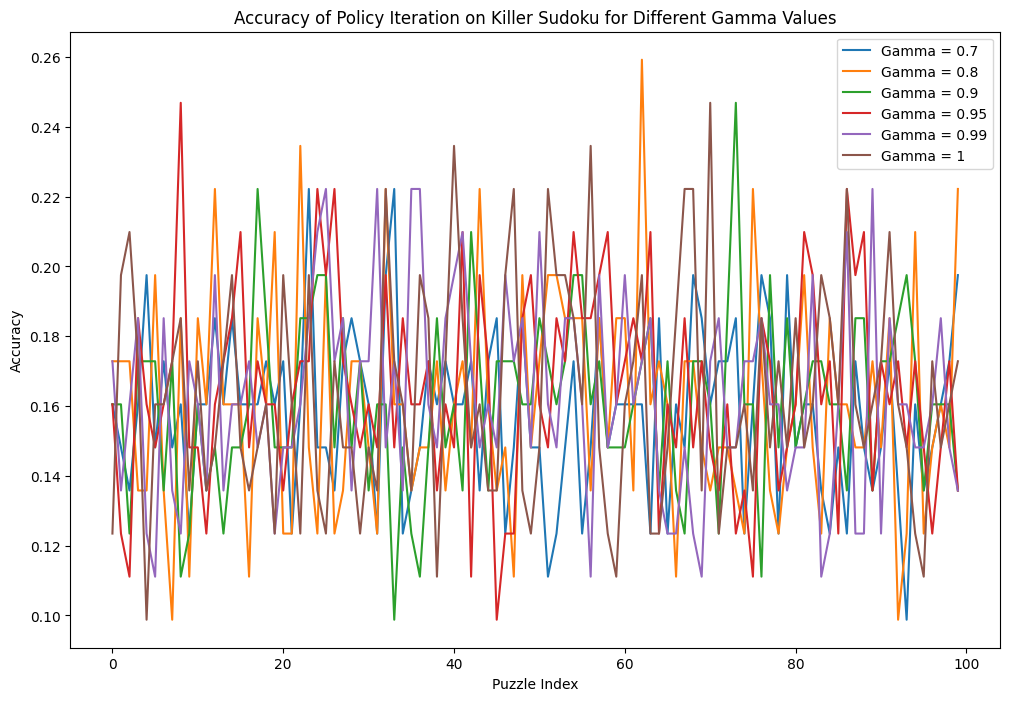

In [ ]:
plt.figure(figsize=(12, 8))
for gamma in gammas:
    plt.plot(range(num_puzzles), results[gamma], label=f'Gamma = {gamma}')
plt.xlabel('Puzzle Index')
plt.ylabel('Accuracy')
plt.title('Accuracy of Policy Iteration on Killer Sudoku for Different Gamma Values')
plt.legend()
plt.show()

Note that the hightes accuracy is about 26% with gamma = 0.8.

# **Method 2: Dynamic Programming with backtracking**

#### **Step 1. Set up the environment and the agent**

The environment is set up the same way as in the previous DP method. However, this approach is not a typical reinforcement learning method in which the agent learns based on rewards, policy and state-action values. The reward function here is merely used to help us visualize how the model performs over time.

The main function for this model is `sudoku_solver(self, row, col)`: it breaks down the whole puzzle into smaller regions and solve them. We used DP so that we can store the solutions of sub problems. And we used backtracking to let the agent explore all the potential solutions, and if the agent runs into a deadend, it can backtrack and explore other potential solutions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time


class DP_Backtracking_Solver:
    def __init__(self, constraints, target_solution, time_limit=60):
        self.constraints = constraints
        self.size = 9
        self.grid = np.zeros((self.size, self.size), dtype=int)
        self.memo = {}
        self.rewards_per_step = []
        self.accuracies_per_step = []
        self.steps = 0
        self.start_time = None
        self.time_limit = time_limit
        self.target_solution = target_solution

    def is_valid(self, row, col, num):
        # Check row
        if num in self.grid[row, :]:
            return False
        # Check column
        if num in self.grid[:, col]:
            return False
        # Check 3x3 box
        box_start_row, box_start_col = 3 * (row // 3), 3 * (col // 3)
        if num in self.grid[box_start_row:box_start_row + 3, box_start_col:box_start_col + 3]:
            return False
        # Check cage constraints
        for total, cells in self.constraints:
            if (row, col) in cells:
                sum_cells = sum(self.grid[r, c] for r, c in cells if (r, c) != (row, col))
                if sum_cells + num > total:
                    return False
                if all(self.grid[r, c] != 0 for r, c in cells):
                    if sum_cells + num != total:
                        return False
        return True

    def calculate_reward(self):
        reward = 0
        # Reward for fully solving the puzzle
        if self.is_done():
            reward += 100

        # Partial rewards for filling rows, columns, boxes, and cages correctly
        reward += self.evaluate_partial_completions()

        # Penalize based on row, column, box, and cage constraints
        reward -= self.evaluate_penalties()

        return reward

    def evaluate_partial_completions(self):
        reward = 0
        for i in range(9):
            if len(set(self.grid[i, :])) == 9:
                reward += 5  # Reward for completing a row
            if len(set(self.grid[:, i])) == 9:
                reward += 5  # Reward for completing a column
        for box_start_row in range(0, 9, 3):
            for box_start_col in range(0, 9, 3):
                if len(set(self.grid[box_start_row:box_start_row + 3, box_start_col:box_start_col + 3].flatten())) == 9:
                    reward += 5  # Reward for completing a box
        for total, cells in self.constraints:
            if sum(self.grid[r, c] for r, c in cells) == total:
                reward += 5  # Reward for satisfying the cage constraint
        return reward

    def evaluate_penalties(self):
        penalty = 0
        # Penalize incomplete rows, columns, and boxes
        penalty += self.evaluate_rows()
        penalty += self.evaluate_columns()
        penalty += self.evaluate_boxes()
        penalty += self.evaluate_cages()
        return penalty

    def evaluate_rows(self):
        penalty = 0
        for row in range(9):
            if not self.is_valid_unit(self.grid[row, :]):
                penalty += 10
        return penalty

    def evaluate_columns(self):
        penalty = 0
        for col in range(9):
            if not self.is_valid_unit(self.grid[:, col]):
                penalty += 10
        return penalty

    def evaluate_boxes(self):
        penalty = 0
        for i in range(0, 9, 3):
            for j in range(0, 9, 3):
                if not self.is_valid_unit(self.grid[i:i + 3, j:j + 3].flatten()):
                    penalty += 10
        return penalty

    def evaluate_cages(self):
        penalty = 0
        for total, cells in self.constraints:
            sum_cells = sum(self.grid[row, col] for row, col in cells)
            if sum_cells != total:
                penalty += 10
        return penalty

    def is_valid_unit(self, unit):
        unit = unit[unit != 0]
        return len(unit) == len(set(unit))

    def is_done(self):
        return np.all(self.grid != 0)

    def calculate_accuracy(self):
        correct_cells = np.sum(self.grid == self.target_solution)
        total_cells = 81
        return correct_cells / total_cells

    def solve(self):
        self.start_time = time.time()
        if self.sudoku_solver(0, 0):
            return self.grid
        else:
            return None

    def sudoku_solver(self, row, col):
        if time.time() - self.start_time > self.time_limit:
            #print("Time limit exceeded.")
            return False

        if row == self.size:
            return True
        if col == self.size:
            return self.sudoku_solver(row + 1, 0)
        if self.grid[row, col] != 0:
            return self.sudoku_solver(row, col + 1)

        state = self.grid.tobytes()
        if state in self.memo:
            return False

        for num in range(1, 10):
            if self.is_valid(row, col, num):
                self.grid[row, col] = num
                self.steps += 1
                reward = self.calculate_reward()
                accuracy = self.calculate_accuracy()
                self.rewards_per_step.append(reward)
                self.accuracies_per_step.append(accuracy)
                if self.sudoku_solver(row, col + 1):
                    return True
                self.grid[row, col] = 0

        self.memo[state] = False
        return False

#### Train the agent


In [ ]:
# Randomly pick a killer sudoku puzzle
random_index = np.random.choice(killer_data.index)
random_killer_sudoku = ast.literal_eval(killer_data.loc[random_index, 'content'])
corresponding_ans = ast.literal_eval(ans_data.loc[random_index, 'content'])

# use the agent to solve the puzzle (increase the time_limit if the puzzle is not solved, more difficult puzzles require more time)
solver = DP_Backtracking_Solver(random_killer_sudoku, corresponding_ans, time_limit=1000)
solution = solver.solve()

#### Plot the results
The following results showed the reward and accuracy over time.

Solved Killer Sudoku:
[[1 2 3 4 5 6 7 8 9]
 [7 6 8 1 9 3 4 5 2]
 [9 4 5 7 8 2 6 1 3]
 [6 8 7 2 1 9 3 4 5]
 [5 9 1 3 4 7 2 6 8]
 [2 3 4 8 6 5 9 7 1]
 [3 5 6 9 7 8 1 2 4]
 [4 7 2 5 3 1 8 9 6]
 [8 1 9 6 2 4 5 3 7]]


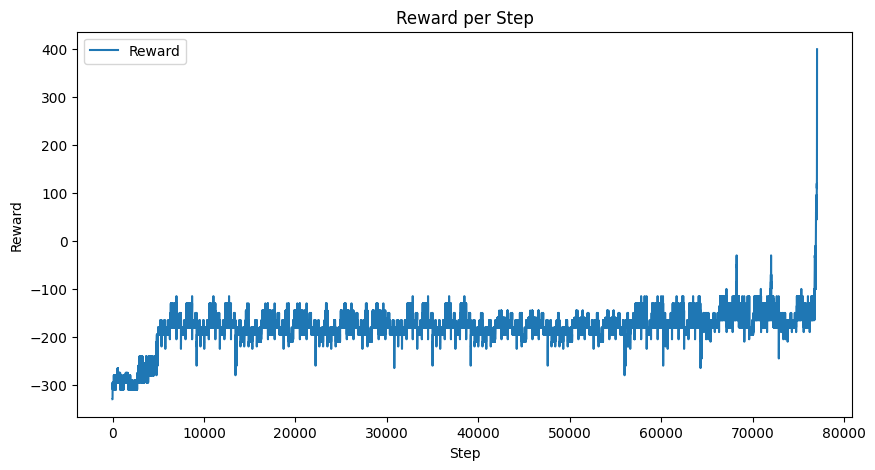

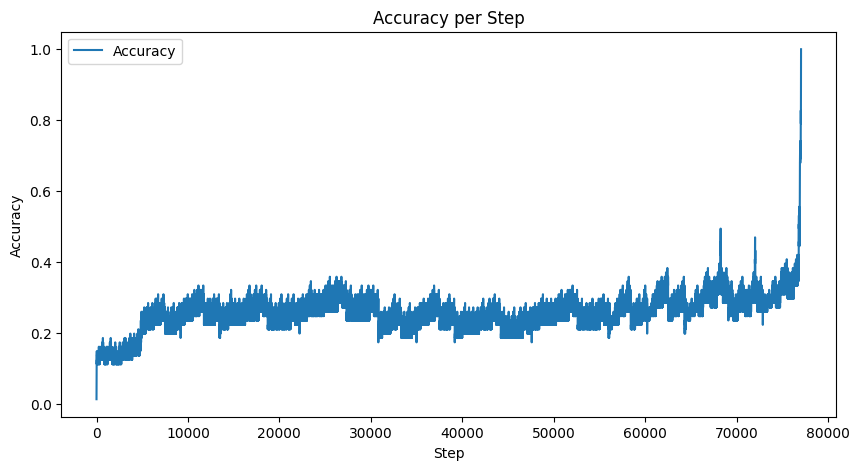

In [ ]:
if solution is not None:
    print("Solved Killer Sudoku:")
    print(solution)
else:
    print("No solution exists or time limit exceeded.")

# Plot rewards per step
plt.figure(figsize=(10, 5))
plt.plot(range(solver.steps), solver.rewards_per_step, label='Reward')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Reward per Step')
plt.legend()
plt.show()

# Plot accuracy per step
plt.figure(figsize=(10, 5))
plt.plot(range(solver.steps), solver.accuracies_per_step, label='Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracy per Step')
plt.legend()
plt.show()

# Method 3: SARSA

Let's start by giving a figurative overview of our problem; in the figure below, the numbers in each grid represent the sum of the corresponding cages, i.e., the answers filled in the grids that have the same number must add up to equal that number. At the same time, all the numbers must conform to the rules of traditional sudoku, as there can be no identical numbers in each row, column, or 3x3 grid.

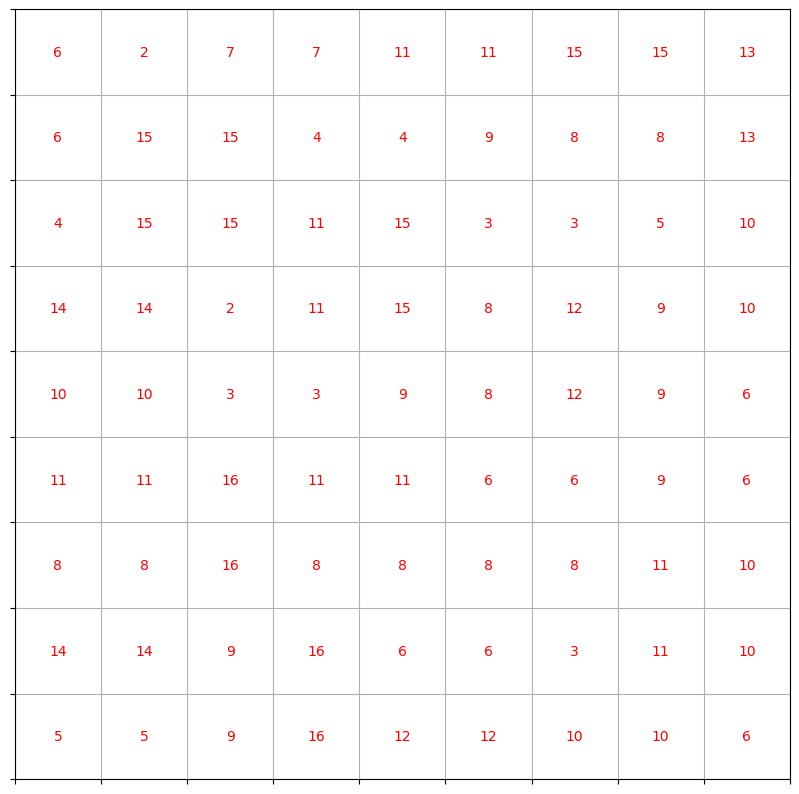

In [ ]:
first_puzzle_data = [
    [11, [(0, 5), (0, 4)]], [10, [(6, 8), (7, 8)]], [8, [(6, 5), (6, 6)]], [14, [(7, 1), (7, 0)]], [15, [(0, 6), (0, 7)]],
    [15, [(2, 1), (2, 2)]], [6, [(5, 6), (5, 5)]], [11, [(7, 7), (6, 7)]], [11, [(2, 3), (3, 3)]], [12, [(4, 6), (3, 6)]],
    [6, [(7, 5), (7, 4)]], [3, [(2, 5), (2, 6)]], [8, [(6, 3), (6, 4)]], [7, [(0, 3), (0, 2)]], [14, [(3, 1), (3, 0)]],
    [10, [(8, 7), (8, 6)]], [10, [(4, 1), (4, 0)]], [5, [(8, 0), (8, 1)]], [6, [(5, 8), (4, 8)]], [11, [(5, 4), (5, 3)]],
    [11, [(5, 0), (5, 1)]], [8, [(1, 6), (1, 7)]], [6, [(0, 0), (1, 0)]], [3, [(4, 2), (4, 3)]], [3, [(7, 6)]],
    [9, [(4, 7), (3, 7)]], [4, [(1, 4), (1, 3)]], [15, [(2, 4), (3, 4)]], [13, [(0, 8), (1, 8)]], [2, [(3, 2)]],
    [16, [(7, 3), (8, 3)]], [12, [(8, 4), (8, 5)]], [16, [(5, 2), (6, 2)]], [4, [(2, 0)]], [15, [(1, 2), (1, 1)]],
    [8, [(6, 1), (6, 0)]], [6, [(8, 8)]], [2, [(0, 1)]], [9, [(5, 7)]], [10, [(3, 8), (2, 8)]], [8, [(4, 5), (3, 5)]],
    [5, [(2, 7)]], [9, [(8, 2), (7, 2)]], [9, [(1, 5)]], [9, [(4, 4)]]
]
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks(range(10))
ax.set_yticks(range(10))
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.gca().invert_yaxis()

for region in first_puzzle_data:
    sum_value = region[0]
    cells = region[1]
    for cell in cells:
        y, x = cell
        ax.text(x + 0.5, y + 0.5, str(sum_value), va='center', ha='center', fontsize=10, color='red')
plt.show()

Then we defined the environment. For the environment class `KillerSudokuEnv` its main functions include

- Initialization: creates a 9x9 sudoku grid, reads and sets the cage and its sum.

- Reset: resets the sudoku grid to all zeros.

- Check for legal moves: verifies that it is legal to place numbers at a specific location.

- Perform Step: Attempts to place the number at the specified location and returns the new grid status, the reward, and whether or not it is complete.

- Check if solved: Determines if the sudoku has been solved. - Render Grid: prints the current Sudoku grid and cage sum.

In [ ]:
class KillerSudokuEnv:
    def __init__(self, puzzle_data):
        self.size = 9
        self.puzzle_data = puzzle_data
        self.grid = np.zeros((self.size, self.size), dtype=int)
        self.regions, self.region_sums = self.initialize_regions(puzzle_data)
        self.reset()

    def initialize_regions(self, puzzle_data):
        regions = {}
        region_sums = {}
        for region_id, (sum_value, cells) in enumerate(puzzle_data, start=1):
            for cell in cells:
                regions[cell] = region_id
            region_sums[region_id] = sum_value
        return regions, region_sums

    def reset(self):
        self.grid = np.zeros((self.size, self.size), dtype=int)
        return self.grid

    def is_valid_move(self, x, y, value):
        if value == 0:
            return False
        if self.grid[x, y] != 0:
            return False
        if value in self.grid[x, :] or value in self.grid[:, y]:
            return False
        if value in self.grid[x//3*3:(x//3+1)*3, y//3*3:(y//3+1)*3]:
            return False
        #区域是否符合限制
        region_id = self.regions[(x, y)]
        region_cells = [cell for cell, rid in self.regions.items() if rid == region_id]
        current_sum = sum(self.grid[cell] for cell in region_cells)
        if current_sum + value > self.region_sums[region_id]:
            return False
        if value in [self.grid[cell] for cell in region_cells if self.grid[cell] != 0]:
            return False
        return True

    def step(self, action):
        x, y, value = action
        if self.is_valid_move(x, y, value):
            self.grid[x, y] = value
            reward = 1  #奖励
            done = self.is_solved()
        else:
            reward = -1.5  #惩罚
            done = False
        return self.grid, reward, done

    def is_solved(self):
        if np.any(self.grid == 0):
            return False
        for region_id, sum_value in self.region_sums.items():
            region_cells = [cell for cell, rid in self.regions.items() if rid == region_id]
            if sum(self.grid[cell] for cell in region_cells) != sum_value:
                return False
        for i in range(self.size):
            if len(set(self.grid[i, :])) != self.size or len(set(self.grid[:, i])) != self.size:
                return False
        return True

    def render(self):
        for i in range(self.size):
            for j in range(self.size):
                if self.grid[i, j] == 0:
                    print('.', end=' ')
                else:
                    print(self.grid[i, j], end=' ')
            print()
        print("\nCages and their sums:")
        for region_id, sum_value in self.region_sums.items():
            print(f"Region {region_id}: sum = {sum_value}")

puzzle_data = [
    [11, [(0, 5), (0, 4)]], [10, [(6, 8), (7, 8)]], [8, [(6, 5), (6, 6)]], [14, [(7, 1), (7, 0)]], [15, [(0, 6), (0, 7)]],
    [15, [(2, 1), (2, 2)]], [6, [(5, 6), (5, 5)]], [11, [(7, 7), (6, 7)]], [11, [(2, 3), (3, 3)]], [12, [(4, 6), (3, 6)]],
    [6, [(7, 5), (7, 4)]], [3, [(2, 5), (2, 6)]], [8, [(6, 3), (6, 4)]], [7, [(0, 3), (0, 2)]], [14, [(3, 1), (3, 0)]],
    [10, [(8, 7), (8, 6)]], [10, [(4, 1), (4, 0)]], [5, [(8, 0), (8, 1)]], [6, [(5, 8), (4, 8)]], [11, [(5, 4), (5, 3)]],
    [11, [(5, 0), (5, 1)]], [8, [(1, 6), (1, 7)]], [6, [(0, 0), (1, 0)]], [3, [(4, 2), (4, 3)]], [3, [(7, 6)]],
    [9, [(4, 7), (3, 7)]], [4, [(1, 4), (1, 3)]], [15, [(2, 4), (3, 4)]], [13, [(0, 8), (1, 8)]], [2, [(3, 2)]],
    [16, [(7, 3), (8, 3)]], [12, [(8, 4), (8, 5)]], [16, [(5, 2), (6, 2)]], [4, [(2, 0)]], [15, [(1, 2), (1, 1)]],
    [8, [(6, 1), (6, 0)]], [6, [(8, 8)]], [2, [(0, 1)]], [9, [(5, 7)]], [10, [(3, 8), (2, 8)]], [8, [(4, 5), (3, 5)]],
    [5, [(2, 7)]], [9, [(8, 2), (7, 2)]], [9, [(1, 5)]], [9, [(4, 4)]]
]

env = KillerSudokuEnv(puzzle_data)
env.render()

. . . . . . . . . 
. . . . . . . . . 
. . . . . . . . . 
. . . . . . . . . 
. . . . . . . . . 
. . . . . . . . . 
. . . . . . . . . 
. . . . . . . . . 
. . . . . . . . . 

Cages and their sums:
Region 1: sum = 11
Region 2: sum = 10
Region 3: sum = 8
Region 4: sum = 14
Region 5: sum = 15
Region 6: sum = 15
Region 7: sum = 6
Region 8: sum = 11
Region 9: sum = 11
Region 10: sum = 12
Region 11: sum = 6
Region 12: sum = 3
Region 13: sum = 8
Region 14: sum = 7
Region 15: sum = 14
Region 16: sum = 10
Region 17: sum = 10
Region 18: sum = 5
Region 19: sum = 6
Region 20: sum = 11
Region 21: sum = 11
Region 22: sum = 8
Region 23: sum = 6
Region 24: sum = 3
Region 25: sum = 3
Region 26: sum = 9
Region 27: sum = 4
Region 28: sum = 15
Region 29: sum = 13
Region 30: sum = 2
Region 31: sum = 16
Region 32: sum = 12
Region 33: sum = 16
Region 34: sum = 4
Region 35: sum = 15
Region 36: sum = 8
Region 37: sum = 6
Region 38: sum = 2
Region 39: sum = 9
Region 40: sum = 10
Region 41: sum = 8
Region 42: sum =

And we train it

In [ ]:
class SARSALearner:
    #Perform various necessary initialization
    def __init__(self, env, alpha=0.001, gamma=0.05, epsilon=0.1, episodes=100):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.episodes = episodes
        self.q_table = defaultdict(lambda: np.zeros((self.env.size, self.env.size, 9)))
        self.restart_count = 0
        self.accuracies = []
        self.action_history = []
    #Select an action to execute and determine if it is available
    def choose_action(self, state):
        valid_actions = []
        for x in range(self.env.size):
            for y in range(self.env.size):
                for value in range(1, 10):
                    if self.env.is_valid_move(x, y, value):
                        valid_actions.append((x, y, value))

        if not valid_actions:
            self.restart_count += 1
            #After repeated testing, we found that if the model is allowed to take a step back
            # and accumulate corresponding penalties when making mistakes, our model performance
            # will be significantly improved
            if self.action_history:
                last_action = self.action_history.pop()
                x, y, _ = last_action
                self.env.grid[x, y] = 0
            return None, -1.5  #here is the panalties

        #ε-greedy algorithm
        if random.uniform(0, 1) < self.epsilon:
          value = random.randint(1, 9)
          action = (x, y, value)
        else:
            state_actions = self.q_table[state]
            max_q_value = -float('inf')
            best_action = None
            for action in valid_actions:
                q_value = state_actions[action[0], action[1], action[2] - 1]
                if q_value > max_q_value:
                    max_q_value = q_value
                    best_action = action

        self.action_history.append(action)
        return action, 0

    #model training
    def train(self):
        for episode in range(self.episodes):
            state = self.env.reset()
            self.action_history = []
            action, penalty = self.choose_action(self.state_to_tuple(state))
            if action is None:
                self.q_table[self.state_to_tuple(state)] += self.alpha * (penalty - self.q_table[self.state_to_tuple(state)])
                continue

            while True:
                next_state, reward, done = self.env.step(action)
                next_action, penalty = self.choose_action(self.state_to_tuple(next_state))
                if next_action is None:
                    self.q_table[self.state_to_tuple(state)][action[0], action[1], action[2] - 1] += self.alpha * (penalty - self.q_table[self.state_to_tuple(state)][action[0], action[1], action[2] - 1])
                    break

                current_q = self.q_table[self.state_to_tuple(state)][action[0], action[1], action[2] - 1]
                next_q = self.q_table[self.state_to_tuple(next_state)][next_action[0], next_action[1], next_action[2] - 1]

                td_target = reward + self.gamma * next_q
                td_error = td_target - current_q

                self.q_table[self.state_to_tuple(state)][action[0], action[1], action[2] - 1] += self.alpha * td_error

                state = next_state
                action = next_action

                if done:
                    break

            #using for test
            #if (episode + 1) % 10 == 0:
                #self.evaluate_accuracy()

    def state_to_tuple(self, state):
        return tuple(map(tuple, state))

In [ ]:
#Define accuracy as how many predicted results of the model are filled in correctly,
#and what is the proportion of model results that match the correct results
def evaluate_accuracy(self):
    correct_solution = np.array([
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [5, 7, 8, 1, 3, 9, 6, 2, 4],
        [4, 9, 6, 8, 7, 2, 1, 5, 3],
        [9, 5, 2, 3, 8, 1, 4, 6, 7],
        [6, 4, 1, 2, 9, 7, 8, 3, 5],
        [3, 8, 7, 5, 6, 4, 2, 9, 1],
        [7, 1, 9, 6, 2, 3, 5, 4, 8],
        [8, 6, 4, 9, 1, 5, 3, 7, 2],
        [2, 3, 5, 7, 4, 8, 9, 1, 6]
    ])
    grid = self.env.grid
    correct_count = np.sum(grid == correct_solution)
    total_count = grid.size
    accuracy = correct_count / total_count * 100
    self.accuracies.append(accuracy)

In [ ]:
# plot
def compare_and_evaluate(grid, correct_solution):
    correct_count = np.sum(grid == correct_solution)
    total_count = grid.size
    accuracy = correct_count / total_count * 100

    #print("Final grid:")
    #for row in grid:
        #print(" ".join(str(num) for num in row))

    #print("\nCorrect solution:")
    #for row in correct_solution:
        #print(" ".join(str(num) for num in row))

    #print(f"\nCorrect numbers: {correct_count}")
    #print(f"Total numbers: {total_count}")
    #print(f"Accuracy: {accuracy:.2f}%")

    return grid, correct_solution

def plot_accuracies(learner):
    plt.plot(range(10, len(learner.accuracies) * 10 + 1, 10), learner.accuracies)
    plt.xlabel('Episodes')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Training Episodes')
    plt.show()

### Grid search for SARSA

Evaluating parameter combination 1 of 100: alpha=0.001, gamma=0.01, epsilon=0.1
Evaluating parameter combination 2 of 100: alpha=0.001, gamma=0.020000000000000004, epsilon=0.1
Evaluating parameter combination 3 of 100: alpha=0.001, gamma=0.030000000000000006, epsilon=0.1
Evaluating parameter combination 4 of 100: alpha=0.001, gamma=0.04000000000000001, epsilon=0.1
Evaluating parameter combination 5 of 100: alpha=0.001, gamma=0.05000000000000001, epsilon=0.1
Evaluating parameter combination 6 of 100: alpha=0.001, gamma=0.06000000000000001, epsilon=0.1
Evaluating parameter combination 7 of 100: alpha=0.001, gamma=0.07, epsilon=0.1
Evaluating parameter combination 8 of 100: alpha=0.001, gamma=0.08, epsilon=0.1
Evaluating parameter combination 9 of 100: alpha=0.001, gamma=0.09000000000000001, epsilon=0.1
Evaluating parameter combination 10 of 100: alpha=0.001, gamma=0.1, epsilon=0.1
Evaluating parameter combination 11 of 100: alpha=0.023111111111111114, gamma=0.01, epsilon=0.1
Evaluating p

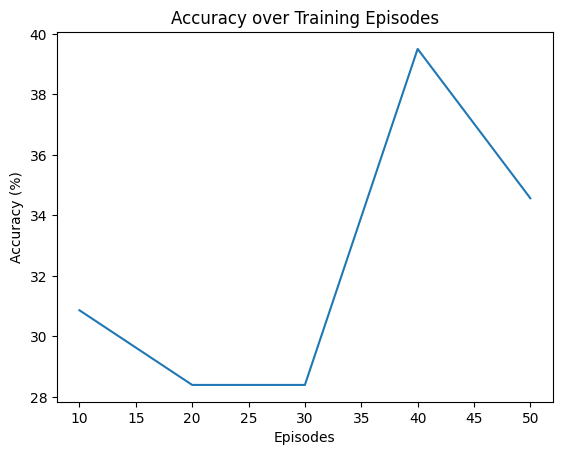

In [ ]:
def grid_search(env, alpha_range, gamma_range, epsilon_range, episodes):
    best_accuracy = 0
    best_params = (None, None, None)
    results = []
    total_combinations = len(alpha_range) * len(gamma_range) * len(epsilon_range)
    count = 0

    for alpha, gamma, epsilon in itertools.product(alpha_range, gamma_range, epsilon_range):
        count += 1
        print(f"Evaluating parameter combination {count} of {total_combinations}: alpha={alpha}, gamma={gamma}, epsilon={epsilon}")

        learner = SARSALearner(env, alpha=alpha, gamma=gamma, epsilon=epsilon, episodes=episodes)
        learner.train()
        final_accuracy = learner.accuracies[-1] if learner.accuracies else 0

        results.append((alpha, gamma, epsilon, final_accuracy))

        if final_accuracy > best_accuracy:
            best_accuracy = final_accuracy
            best_params = (alpha, gamma, epsilon)

    return best_params, results

alpha_range = np.linspace(0.001, 0.2, 10)
gamma_range = np.linspace(0.01, 0.1, 10)
epsilon_range = np.linspace(0.1, 0.1, 1)
episodes = 50

env = KillerSudokuEnv(first_puzzle_data)
best_params, results = grid_search(env, alpha_range, gamma_range, epsilon_range, episodes)

print(f"Best Parameters: alpha={best_params[0]}, gamma={best_params[1]}, epsilon={best_params[2]}")
print("All Results:")
for alpha, gamma, epsilon, accuracy in results:
    print(f"alpha={alpha}, gamma={gamma}, epsilon={epsilon}, accuracy={accuracy:.2f}%")

best_alpha, best_gamma, best_epsilon = best_params
learner = SARSALearner(env, alpha=best_alpha, gamma=best_gamma, epsilon=best_epsilon, episodes=episodes)
final_grid = learner.train()

correct_solution = np.array([
    [1, 2, 3, 4, 5, 6, 7, 8, 9],
    [5, 7, 8, 1, 3, 9, 6, 2, 4],
    [4, 9, 6, 8, 7, 2, 1, 5, 3],
    [9, 5, 2, 3, 8, 1, 4, 6, 7],
    [6, 4, 1, 2, 9, 7, 8, 3, 5],
    [3, 8, 7, 5, 6, 4, 2, 9, 1],
    [7, 1, 9, 6, 2, 3, 5, 4, 8],
    [8, 6, 4, 9, 1, 5, 3, 7, 2],
    [2, 3, 5, 7, 4, 8, 9, 1, 6]
])
compare_and_evaluate(final_grid, correct_solution)

### Perform deep training on parameters that perform well

Training with alpha=0.023111111111111114, gamma=0.07, epsilon=0.1
Final grid:
2 0 0 0 7 4 8 1 3
0 7 3 1 2 5 0 6 9
4 0 8 6 3 0 2 5 7
9 3 0 5 6 1 0 2 0
0 6 2 0 8 7 9 3 1
1 4 7 2 9 0 6 8 5
0 8 9 0 1 3 5 4 2
0 1 4 9 0 6 3 7 8
3 2 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 22
Total numbers: 81
Accuracy: 27.16%


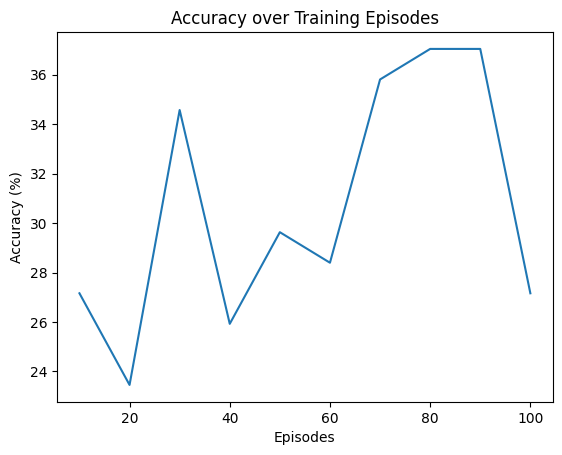

Training with alpha=0.045222222222222226, gamma=0.030000000000000006, epsilon=0.1
Final grid:
5 0 0 3 1 9 8 6 4
1 0 6 0 2 7 5 0 9
0 4 8 0 6 0 2 1 3
4 6 1 8 9 3 0 2 7
0 7 0 0 5 2 9 3 1
3 2 9 4 7 0 6 8 5
0 8 7 1 3 5 0 4 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 16
Total numbers: 81
Accuracy: 19.75%


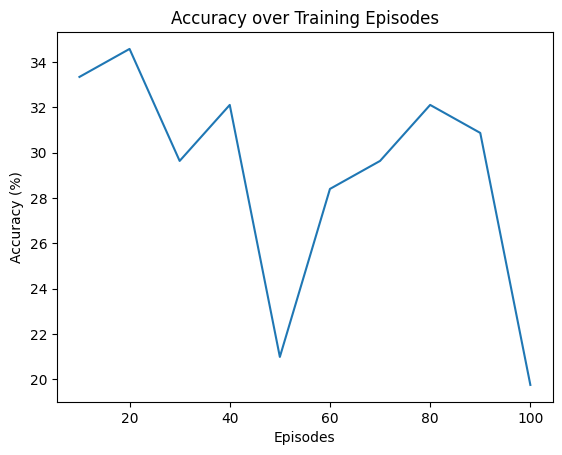

Training with alpha=0.06733333333333334, gamma=0.04000000000000001, epsilon=0.1
Final grid:
0 0 6 0 0 9 7 1 0
4 7 3 0 2 5 0 6 9
0 0 8 4 7 1 2 3 5
5 9 1 6 3 0 0 2 4
0 6 2 1 8 7 9 5 3
3 4 7 2 9 0 6 8 1
7 0 9 0 1 3 5 4 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 23
Total numbers: 81
Accuracy: 28.40%


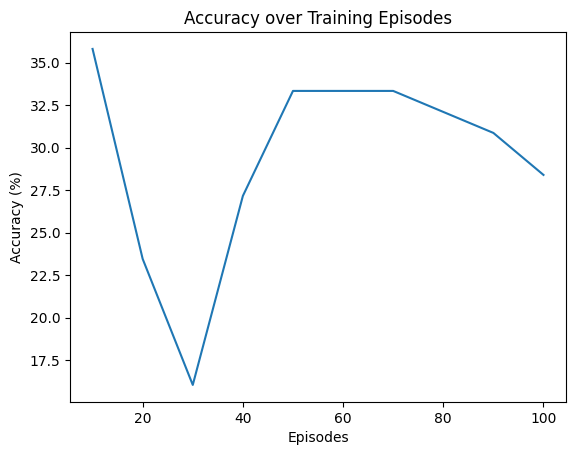

Training with alpha=0.06733333333333334, gamma=0.1, epsilon=0.1
Final grid:
5 0 0 0 0 2 9 6 4
0 2 8 3 0 4 0 1 7
4 0 6 8 7 0 2 5 0
0 7 2 0 6 1 4 3 9
0 9 3 0 8 5 7 2 1
0 4 1 2 9 0 6 8 5
0 8 9 0 1 3 5 4 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 24
Total numbers: 81
Accuracy: 29.63%


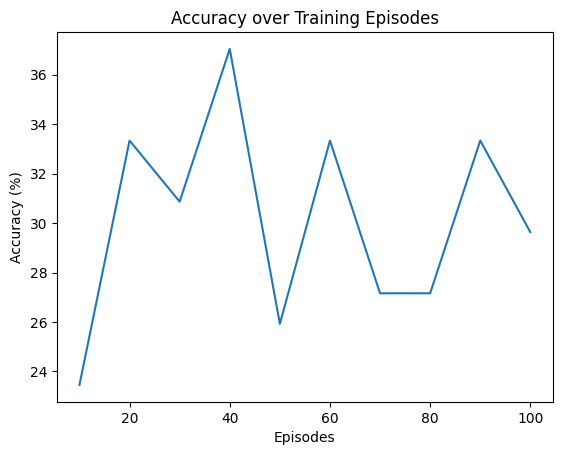

Training with alpha=0.08944444444444445, gamma=0.01, epsilon=0.1
Final grid:
0 0 0 5 2 0 7 1 4
5 7 3 1 0 0 0 8 9
0 6 8 4 0 0 2 5 3
4 5 2 6 9 1 0 3 7
8 0 0 0 3 7 9 2 1
1 9 7 8 0 2 4 6 5
0 8 9 0 1 3 5 4 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 27
Total numbers: 81
Accuracy: 33.33%


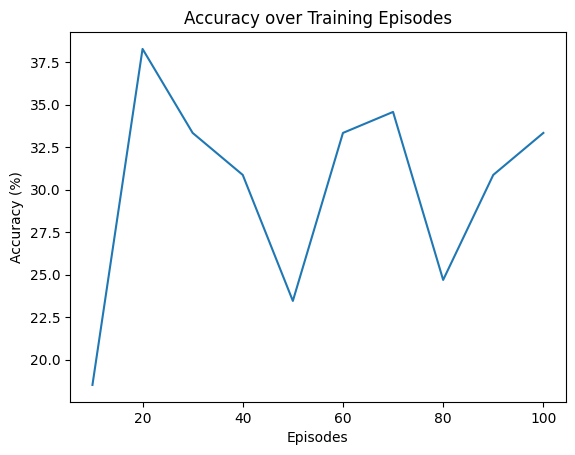

Training with alpha=0.08944444444444445, gamma=0.05000000000000001, epsilon=0.1
Final grid:
0 2 1 4 0 9 8 6 3
0 7 6 1 0 5 4 2 9
4 0 8 3 7 2 0 5 1
0 9 0 5 6 1 2 3 7
0 6 2 0 8 7 9 1 0
3 4 7 2 9 0 6 8 5
0 8 9 0 1 3 5 4 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 29
Total numbers: 81
Accuracy: 35.80%


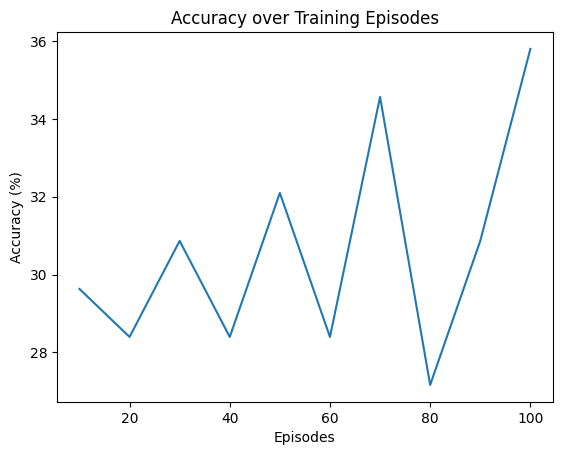

Training with alpha=0.08944444444444445, gamma=0.09000000000000001, epsilon=0.1
Final grid:
0 2 0 6 0 4 8 1 9
1 9 0 0 3 5 6 2 4
0 4 6 2 7 1 0 5 3
0 6 1 5 8 0 2 0 7
4 5 0 3 6 7 9 8 1
3 7 8 1 9 2 4 6 5
0 8 7 0 1 3 5 4 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 28
Total numbers: 81
Accuracy: 34.57%


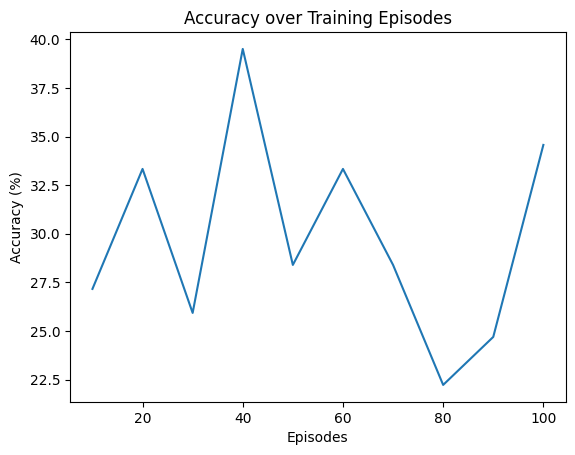

Training with alpha=0.11155555555555556, gamma=0.01, epsilon=0.1
Final grid:
0 0 3 4 0 9 8 1 0
5 7 0 0 3 1 2 6 9
4 0 8 6 7 2 0 5 3
0 9 1 5 6 0 0 2 7
0 6 2 0 8 7 9 3 1
3 4 7 2 9 0 6 8 5
0 8 9 0 1 3 5 4 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 30
Total numbers: 81
Accuracy: 37.04%


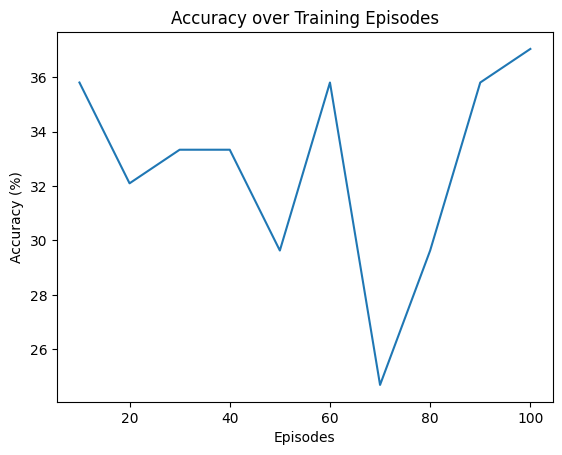

Training with alpha=0.11155555555555556, gamma=0.030000000000000006, epsilon=0.1
Final grid:
0 0 0 1 2 4 0 6 3
6 2 0 0 3 5 7 1 9
3 0 8 6 7 0 2 5 0
8 0 0 5 6 1 0 2 7
0 6 2 0 8 7 9 3 1
1 4 7 2 9 0 6 8 5
0 8 9 0 1 3 5 4 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 23
Total numbers: 81
Accuracy: 28.40%


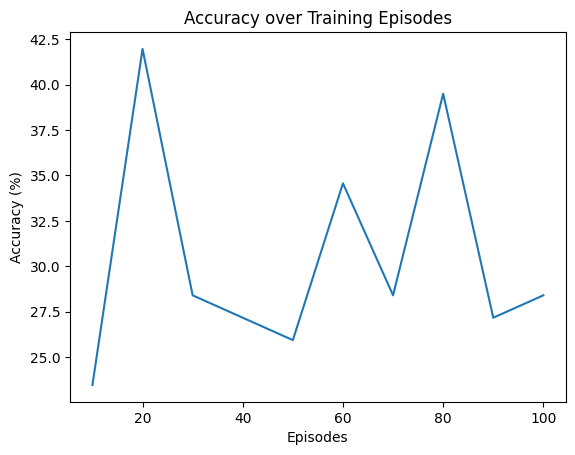

Training with alpha=0.11155555555555556, gamma=0.04000000000000001, epsilon=0.1
Final grid:
0 0 2 4 0 5 0 1 0
5 7 0 0 3 0 0 6 9
4 0 8 6 7 1 2 5 3
0 9 1 5 6 4 0 2 7
0 6 0 0 8 2 9 3 1
3 4 7 1 9 0 6 8 5
0 8 9 0 1 3 5 4 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 27
Total numbers: 81
Accuracy: 33.33%


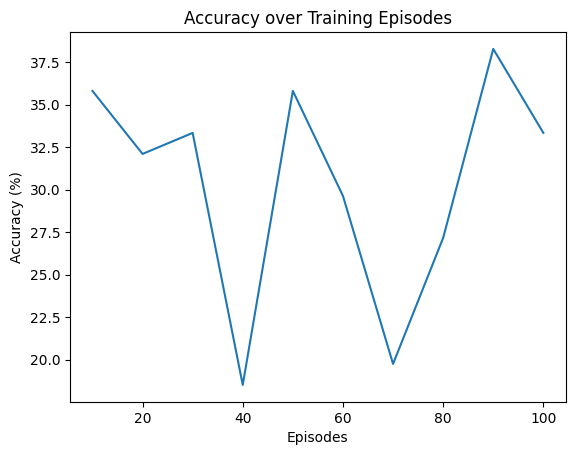

Training with alpha=0.11155555555555556, gamma=0.05000000000000001, epsilon=0.1
Final grid:
0 0 0 1 0 9 2 6 4
6 0 2 0 3 5 7 1 9
1 0 8 6 7 2 0 5 3
0 9 0 5 6 1 0 2 7
0 6 0 3 8 7 9 4 1
3 4 7 2 9 0 6 8 5
0 8 9 0 1 3 5 0 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 24
Total numbers: 81
Accuracy: 29.63%


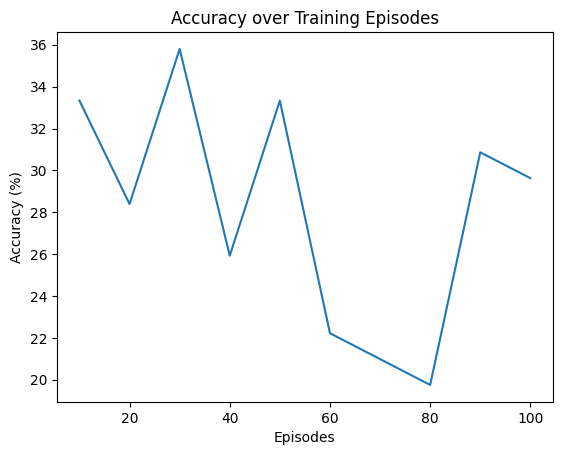

Training with alpha=0.13366666666666668, gamma=0.030000000000000006, epsilon=0.1
Final grid:
0 0 1 5 0 9 8 2 4
0 5 0 1 3 7 0 6 9
4 7 8 6 0 2 0 5 3
5 9 0 4 6 1 2 0 7
0 6 2 0 8 5 9 3 1
3 4 7 2 9 0 6 8 5
0 8 9 0 1 3 5 4 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 26
Total numbers: 81
Accuracy: 32.10%


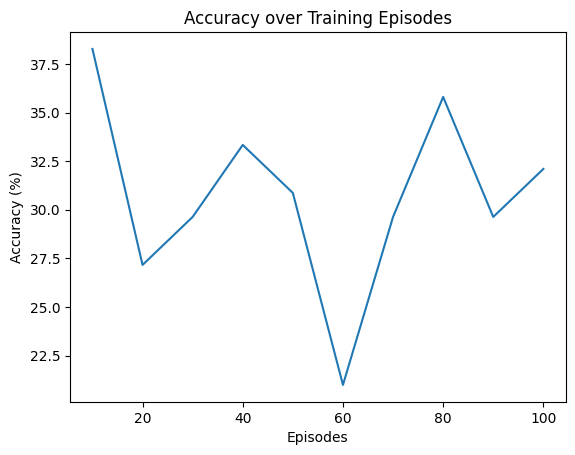

Training with alpha=0.1557777777777778, gamma=0.020000000000000004, epsilon=0.1
Final grid:
0 0 3 0 6 4 7 0 5
5 7 8 0 3 9 0 6 1
1 4 6 8 7 0 0 2 3
0 9 2 0 5 1 0 3 7
4 6 0 3 8 7 9 5 2
3 5 7 2 9 0 6 8 4
0 8 9 1 2 3 5 4 0
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 33
Total numbers: 81
Accuracy: 40.74%


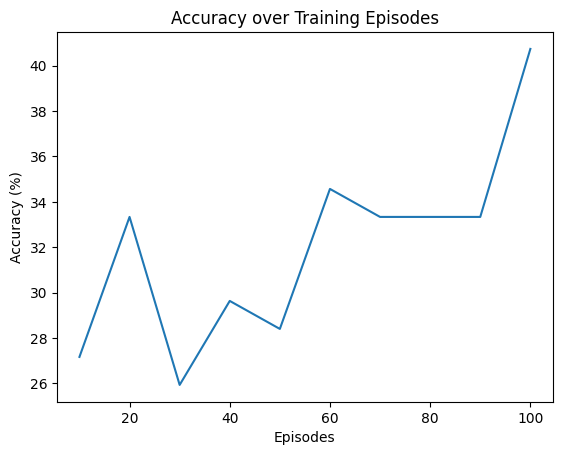

Training with alpha=0.1557777777777778, gamma=0.09000000000000001, epsilon=0.1
Final grid:
0 0 2 0 5 0 8 0 4
5 7 8 0 0 6 3 1 9
0 1 3 4 7 0 0 5 2
0 9 1 6 2 0 0 3 7
4 5 0 3 8 7 9 6 1
6 2 7 0 9 1 4 8 5
0 8 9 2 6 3 5 4 0
0 6 4 9 1 5 2 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 26
Total numbers: 81
Accuracy: 32.10%


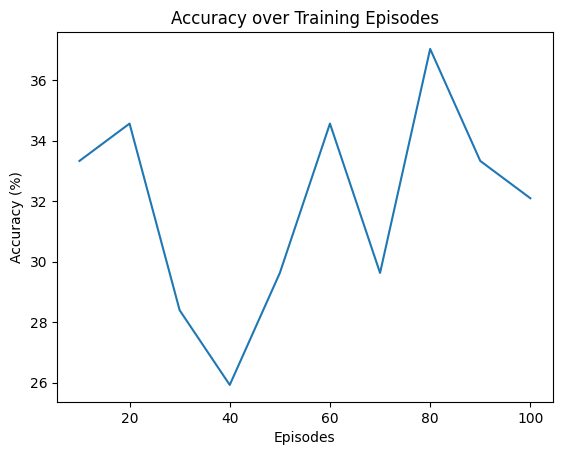

Training with alpha=0.1778888888888889, gamma=0.030000000000000006, epsilon=0.1
Final grid:
3 0 6 0 0 4 9 5 2
0 2 7 1 3 5 0 6 8
0 4 8 6 7 2 0 3 0
8 0 0 5 6 0 2 0 9
0 9 2 0 8 7 5 4 1
4 5 1 2 9 0 6 7 3
0 8 9 3 5 1 7 2 4
1 7 4 9 0 6 3 8 5
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 16
Total numbers: 81
Accuracy: 19.75%


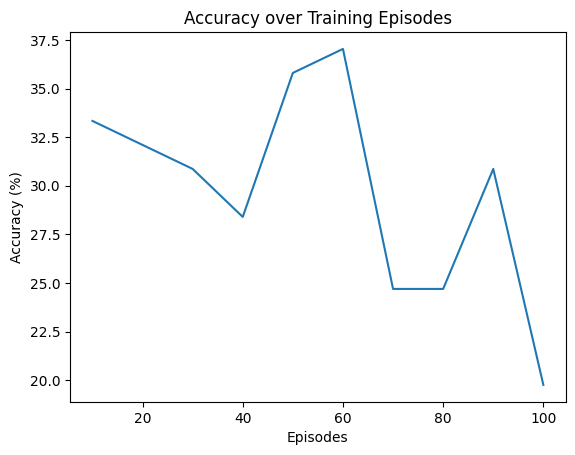

Training with alpha=0.2, gamma=0.01, epsilon=0.1
Final grid:
6 0 0 0 7 2 8 1 4
0 2 0 1 3 5 0 6 9
4 0 1 6 9 0 2 5 3
0 8 0 4 6 1 0 2 7
0 5 2 0 8 7 9 3 1
3 4 7 9 2 0 6 8 5
0 7 8 0 1 3 5 4 2
1 9 4 5 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 24
Total numbers: 81
Accuracy: 29.63%


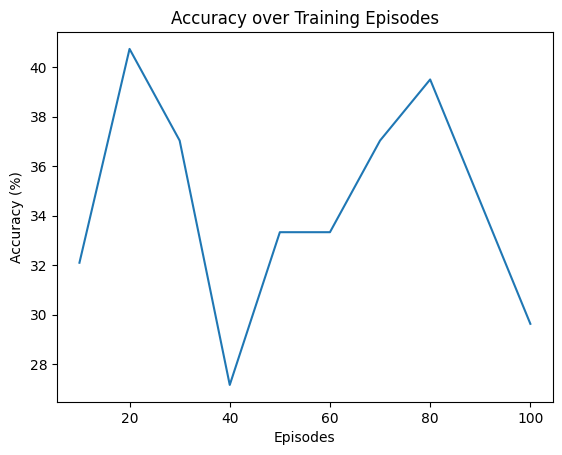

Training with alpha=0.2, gamma=0.06000000000000001, epsilon=0.1
Final grid:
0 0 0 6 3 7 8 1 4
4 0 3 0 2 5 0 6 9
0 7 8 4 0 1 2 5 3
0 9 1 5 6 4 0 2 7
0 6 2 0 8 0 9 3 1
3 4 7 2 9 0 6 8 5
0 8 9 0 1 3 5 4 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 21
Total numbers: 81
Accuracy: 25.93%


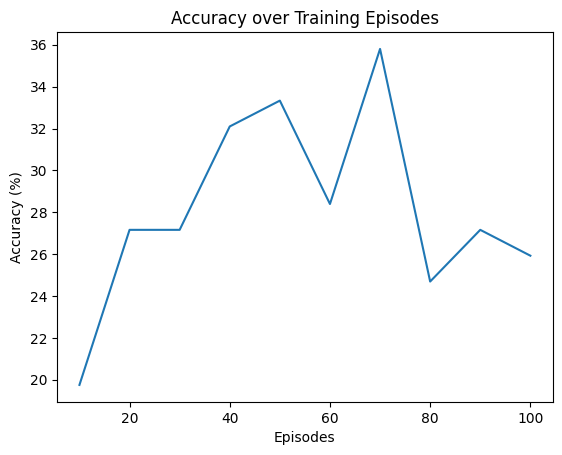

Training with alpha=0.2, gamma=0.09000000000000001, epsilon=0.1
Final grid:
0 0 0 0 2 9 8 1 4
0 7 8 3 1 4 0 6 9
4 0 6 8 7 0 2 5 3
5 9 0 1 6 2 0 0 7
0 6 2 0 8 5 9 3 1
3 4 7 0 9 0 6 8 5
0 8 9 0 0 3 5 4 2
0 1 4 9 0 6 3 7 8
2 3 5 7 4 8 1 9 6

Correct solution:
1 2 3 4 5 6 7 8 9
5 7 8 1 3 9 6 2 4
4 9 6 8 7 2 1 5 3
9 5 2 3 8 1 4 6 7
6 4 1 2 9 7 8 3 5
3 8 7 5 6 4 2 9 1
7 1 9 6 2 3 5 4 8
8 6 4 9 1 5 3 7 2
2 3 5 7 4 8 9 1 6

Correct numbers: 27
Total numbers: 81
Accuracy: 33.33%


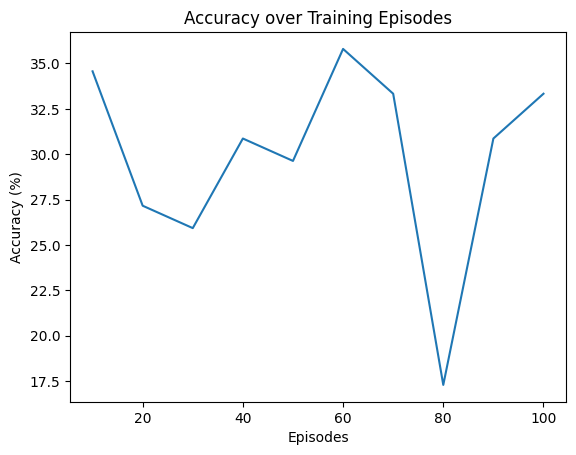

In [ ]:
#使用表现较好的参数进行深度训练
params = [
    (0.023111111111111114, 0.07, 0.1),
    (0.045222222222222226, 0.030000000000000006, 0.1),
    (0.06733333333333334, 0.04000000000000001, 0.1),
    (0.06733333333333334, 0.1, 0.1),
    (0.08944444444444445, 0.01, 0.1),
    (0.08944444444444445, 0.05000000000000001, 0.1),
    (0.08944444444444445, 0.09000000000000001, 0.1),
    (0.11155555555555556, 0.01, 0.1),
    (0.11155555555555556, 0.030000000000000006, 0.1),
    (0.11155555555555556, 0.04000000000000001, 0.1),
    (0.11155555555555556, 0.05000000000000001, 0.1),
    (0.13366666666666668, 0.030000000000000006, 0.1),
    (0.1557777777777778, 0.020000000000000004, 0.1),
    (0.1557777777777778, 0.09000000000000001, 0.1),
    (0.1778888888888889, 0.030000000000000006, 0.1),
    (0.2, 0.01, 0.1),
    (0.2, 0.06000000000000001, 0.1),
    (0.2, 0.09000000000000001, 0.1)
]

for alpha, gamma, epsilon in params:
    env = KillerSudokuEnv(first_puzzle_data)
    learner = SARSALearner(env, alpha=alpha, gamma=gamma, epsilon=epsilon, episodes=100)
    final_grid = learner.train()
    correct_solution = np.array([
        [1, 2, 3, 4, 5, 6, 7, 8, 9],
        [5, 7, 8, 1, 3, 9, 6, 2, 4],
        [4, 9, 6, 8, 7, 2, 1, 5, 3],
        [9, 5, 2, 3, 8, 1, 4, 6, 7],
        [6, 4, 1, 2, 9, 7, 8, 3, 5],
        [3, 8, 7, 5, 6, 4, 2, 9, 1],
        [7, 1, 9, 6, 2, 3, 5, 4, 8],
        [8, 6, 4, 9, 1, 5, 3, 7, 2],
        [2, 3, 5, 7, 4, 8, 9, 1, 6]
    ])
    print(f"Training with alpha={alpha}, gamma={gamma}, epsilon={epsilon}")
    compare_and_evaluate(final_grid, correct_solution)
    plot_accuracies(learner)

### Test the SARSA algorithm

In [ ]:
random_questions = killer_data.sample(10000)
all_accuracies = []

for idx, row in random_questions.iterrows():
    puzzle_index = row['index']
    puzzle_data = eval(row['content'])

    env = KillerSudokuEnv(puzzle_data)
    learner = SARSALearner(env, alpha=0.15, gamma=0.2, epsilon=0.1, episodes=1000)
    result_grid = learner.train()

    correct_solution = eval(ans_data[ans_data['index'] == puzzle_index]['content'].values[0])
    correct_solution = np.array(correct_solution)

    final_grid, correct_grid = compare_and_evaluate(result_grid, correct_solution)
    accuracy = (np.sum(final_grid == correct_grid)) / correct_grid.size * 100
    all_accuracies.append(accuracy)

average_accuracy = np.mean(all_accuracies)

Average accuracy: 15.06%


# Method 4: CNN algorithm

For the CNN model, we have made different treatments by combining our cage with blank questions to form a special question with cage features, which better enables CNN to capture the features of the cage and the relationship between the cage and the correct results

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def process_killer_sudoku(ans_file, killer_file):
    # Read data
    ans_data = pd.read_csv(ans_file)
    killer_data = pd.read_csv(killer_file)

    # Extract raw features and labels
    ans_raw = ans_data['content']
    killer_raw = killer_data['content']

    x_data = []
    y_data = []
    hint_data = []
    cage_constraints_data = []

    for i in tqdm(range(len(ans_raw))):
        # Process Sudoku solution
        sol = np.array([int(num) for num in ans_raw[i] if num.isdigit()]).reshape((9, 9)) - 1
        y_data.append(sol)

        # Process Killer Sudoku hint information
        killer_raw_item = eval(killer_raw[i])

        # Create hint matrix
        hint_matrix = np.zeros((9, 9))
        for sum_value, cells in killer_raw_item:
            for cell in cells:
                # Correct value that should be filled
                correct_value = sol[cell[0], cell[1]] + 1  # +1 to offset the -1 earlier
                normalized_value = correct_value * sum_value / (9 * len(cells))
                hint_matrix[cell[0], cell[1]] = normalized_value

        # Combine empty puzzle with hint matrix
        combined_puzzle = hint_matrix
        x_data.append(combined_puzzle)

        hint_data.append(hint_matrix)
        cage_constraints_data.append(killer_raw_item)

    x_data = np.array(x_data)
    y_data = np.array(y_data)
    hint_data = np.array(hint_data)
    cage_constraints_data = np.array(cage_constraints_data)

    # Ensure consistent ordering when splitting
    x_train, x_test, y_train, y_test, hint_train, hint_test, cage_constraints_train, cage_constraints_test = train_test_split(
        x_data, y_data, hint_data, cage_constraints_data, test_size=0.2, random_state=42)

    return x_train, x_test, y_train, y_test, hint_train, hint_test, cage_constraints_train, cage_constraints_test

In [ ]:
class KillerSudokuDataset(Dataset):
    def __init__(self, x_data, y_data, hint_data, cage_constraints_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.long)
        self.hint_data = torch.tensor(hint_data, dtype=torch.float32)
        self.cage_constraints_data = cage_constraints_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return (
            self.x_data[idx],
            self.y_data[idx],
            self.hint_data[idx],
            self.cage_constraints_data[idx]
        )

def collate_fn(batch):
    x_data = torch.stack([item[0] for item in batch])
    y_data = torch.stack([item[1] for item in batch])
    hint_data = torch.stack([item[2] for item in batch])
    cage_constraints_data = [item[3] for item in batch]
    return x_data, y_data, hint_data, cage_constraints_data

In [ ]:
#Data processing
ans_file = 'https://raw.githubusercontent.com/DevinChen02/COGS188_GroupAAA_Project/main/data/ans_data.csv'
killer_file = 'https://raw.githubusercontent.com/DevinChen02/COGS188_GroupAAA_Project/main/data/killer_data.csv'
x_train, x_test, y_train, y_test, hint_train, hint_test, cage_constraints_train, cage_constraints_test = process_killer_sudoku(ans_file, killer_file)

#Create custom datasets and DataLoaders
train_dataset = KillerSudokuDataset(x_train, y_train, hint_train, cage_constraints_train)
test_dataset = KillerSudokuDataset(x_test, y_test, hint_test, cage_constraints_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

100%|██████████| 12000/12000 [00:05<00:00, 2098.08it/s]
C:\Users\22697\AppData\Local\Temp\ipykernel_19588\2028904716.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cage_constraints_data = np.array(cage_constraints_data)


### **Important note**

We had originally planned to only provide the CNN with the position of the cages and the sum of the cages, which is exemplified in the figure below.

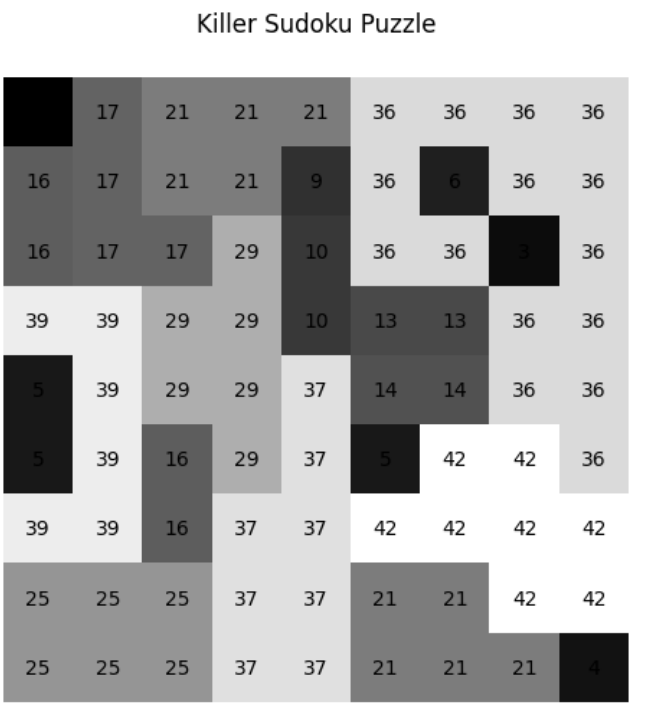


 However, we found that such a feature was too vague for the CNN and the model was not able to capture the features in it well (only 43% accuracy). So we added the percentage of each correct number to the sum of the cages to the topic. By adding this percentage model can capture the features of the cages better than the features of each individual correct answer for each cage for better learning

Here is a presentation of our Sudoku questions and answers

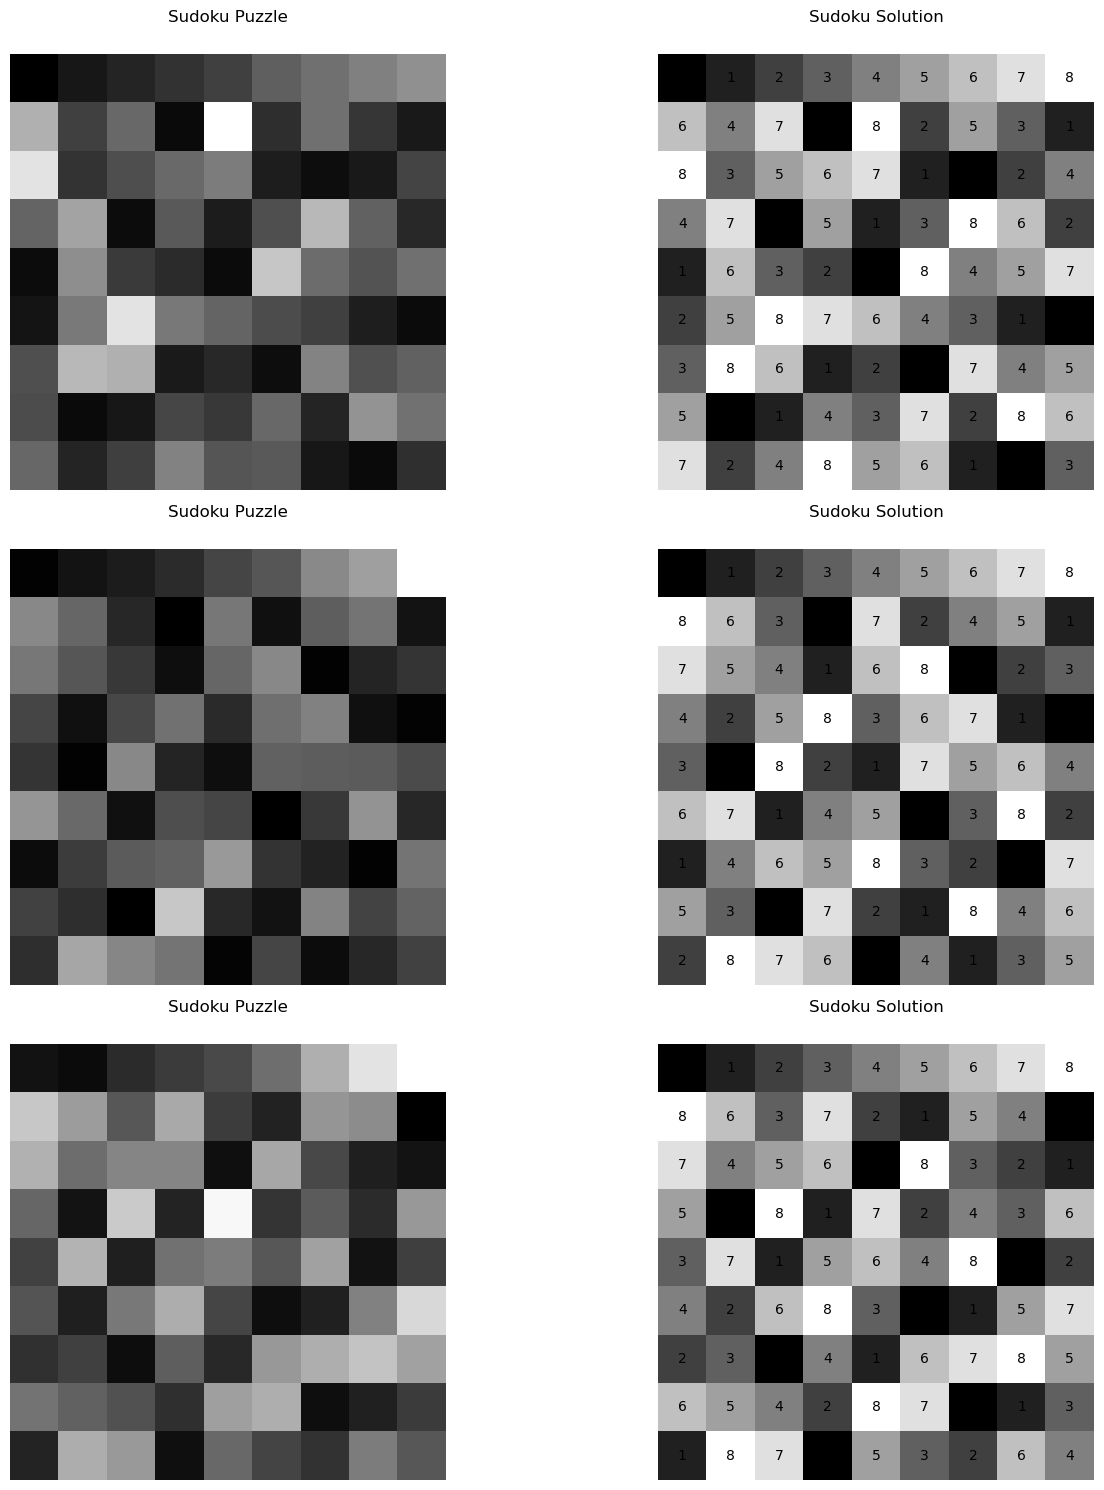

In [ ]:
def display_sudoku_samples(x_data, y_data, num_samples=3):
    fig, axs = plt.subplots(num_samples, 2, figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        #problem
        ax = axs[i, 0]
        puzzle = x_data[i].reshape((9, 9))
        ax.matshow(puzzle, cmap='gray')
        ax.set_title('Sudoku Puzzle')
        ax.axis('off')

        #answer
        ax = axs[i, 1]
        solution = y_data[i]
        ax.matshow(solution, cmap='gray')
        for (j, k), val in np.ndenumerate(solution):
            ax.text(k, j, int(val), ha='center', va='center')
        ax.set_title('Sudoku Solution')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 使用函数展示数据
display_sudoku_samples(x_train, y_train, num_samples=3)

## Defining Conv2dSame and SudokuCNN

The Conv2dSame class is used to create 2D convolutional layers with the same padding. At initialization, it accepts the number of input channels in_channels, the number of output channels out_channels, the size of the convolution kernel kernel_size, whether to use bias bias (defaults to True) and the padding type padding_layer (defaults to nn.ReflectionPad2d). In the __init__ method, it constructs a sequence network containing a reflection padding layer, a convolutional layer, a batch normalization layer, and a ReLU activation function.

The SudokuCNN class is used to define a convolutional neural network model for solving Sudoku problems. It inherits from nn.Module. At initialization, it defines a series of convolutional layers conv_layers, including 15 Conv2dSame layers, each with an increasing number of output channels, and a final convolutional layer last_conv, which outputs the probability of the number of digits in each cell. In the forward method, the input data is passed through conv_layers for feature extraction, and then through last_conv to output the prediction result.

In [ ]:
class Conv2dSame(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, bias=True, padding_layer=nn.ReflectionPad2d):
        """It only support square kernels and stride=1, dilation=1, groups=1."""
        super(Conv2dSame, self).__init__()
        ka = kernel_size // 2
        kb = ka - 1 if kernel_size % 2 == 0 else ka
        self.net = nn.Sequential(
            padding_layer((ka, kb, ka, kb)),
            nn.Conv2d(in_channels, out_channels, kernel_size, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
    def forward(self, x):
        return self.net(x)

class SudokuCNN(nn.Module):
    def __init__(self):
        super(SudokuCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            Conv2dSame(2, 64, 3),  # Update input channels to 2
            Conv2dSame(64, 128, 3),
            Conv2dSame(128, 256, 3),
            Conv2dSame(256, 512, 3),
            Conv2dSame(512, 512, 3),
            Conv2dSame(512, 512, 3),
            Conv2dSame(512, 512, 3),
            Conv2dSame(512, 512, 3),
            Conv2dSame(512, 512, 3),
            Conv2dSame(512, 512, 3),
            Conv2dSame(512, 512, 3),
            Conv2dSame(512, 512, 3),
            Conv2dSame(512, 512, 3),
            Conv2dSame(512, 512, 3),
            Conv2dSame(512, 512, 3),
            Conv2dSame(512, 512, 3),
            Conv2dSame(512, 512, 3),
        )
        self.last_conv = nn.Conv2d(512, 9, 1)
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.last_conv(x)
        return x

### Custom loss function
The function will first perform shape transformation on the output and target to adapt to the calculation of the cross entropy loss function. Then, the cross entropy loss function is used to calculate the loss between the predicted results of the model and the true labels. Next, convert the output into a probability distribution and calculate the constraint loss based on the cage constraint cage constraints. For each sample, traverse the cage constraint list, calculate the mean square error (MSE) between the sum of predicted cage numbers and the target value, and accumulate these losses to obtain the cage constraint loss. Finally, add the cross entropy loss and cage constraint loss to obtain the total loss value, and use the total loss value, cross entropy loss, and cage constraint loss values as the return values of the function.

In [ ]:
def custom_loss(output, target, hint, cage_constraints, criterion, iteration, log_interval):
    # Compute standard cross-entropy loss
    batch_size, num_classes, height, width = output.shape
    output = output.view(batch_size, num_classes, -1).transpose(1, 2).contiguous().view(-1, num_classes)
    target = target.view(-1)

    # Ensure target labels are within [0, 8]
    if target.min() < 0 or target.max() >= num_classes:
        raise ValueError(f"Target has values out of bounds: {target.min()} to {target.max()}")

    cross_entropy_loss = criterion(output, target)

    # Convert logits to probabilities
    output_prob = F.softmax(output, dim=1).view(batch_size, height, width, num_classes).permute(0, 3, 1, 2).contiguous()

    # Compute cage constraint loss
    cage_loss = 0
    for b in range(batch_size):
        for sum_value, cells in cage_constraints[b]:
            predicted_sum = sum(output_prob[b, :, cell[0], cell[1]].sum().item() for cell in cells)
            predicted_sum_tensor = torch.tensor([predicted_sum], dtype=torch.float32).to(target.device)
            sum_value_tensor = torch.tensor([sum_value], dtype=torch.float32).to(target.device)
            cage_loss += F.mse_loss(predicted_sum_tensor, sum_value_tensor)

    # Normalize cage_loss
    cage_loss = cage_loss / batch_size

    # Combine losses
    total_loss = cross_entropy_loss + cage_loss
    return total_loss, cross_entropy_loss.item(), cage_loss.item()

### Training function and Evaluation function

In [ ]:
def train_net(epoch, n_epochs, net, criterion, optimizer, device, train_loader, log_interval=300):
    net.train()
    running_loss = 0.0
    grad_update_counter = 0

    epoch_cross_entropy_losses = []
    epoch_cage_losses = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{n_epochs}', leave=False)

    for batch_i, data in progress_bar:
        sudoku = data[0]
        target = data[1]
        hint = data[2]
        cage_constraints = data[3]

        # Combine Sudoku puzzles and hint information as input
        input_data = torch.stack((sudoku, hint), dim=1)  # Shape [batch_size, 2, 9, 9]

        optimizer.zero_grad()

        input_data = input_data.to(device)
        target = target.to(device)
        sudoku = Variable(input_data)
        target = Variable(target)

        output = net(sudoku)

        loss, cross_entropy_loss, cage_loss = custom_loss(output, target, hint, cage_constraints, criterion, batch_i, log_interval)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        grad_update_counter += 1

        epoch_cross_entropy_losses.append(cross_entropy_loss)
        epoch_cage_losses.append(cage_loss)

        if grad_update_counter >= log_interval:
            avg_loss = running_loss / log_interval
            progress_bar.set_postfix(loss=avg_loss)
            running_loss = 0.0
            grad_update_counter = 0

    return epoch_cross_entropy_losses, epoch_cage_losses

In [ ]:
def val_net(epoch, n_epochs, net, criterion, device, test_loader):
    net.eval()
    val_loss = 0.0
    correct_digits = 0
    total_digits = 0
    with torch.set_grad_enabled(False):
        for i, data in enumerate(test_loader):
            sudoku = data[0].to(device)
            target = data[1].to(device)  # Ensure target is in the range [0, 8]
            hint = data[2].to(device)

            # Ensure input data shape is correct
            input_data = torch.stack((sudoku, hint), dim=1).to(device)  # Shape [batch_size, 2, 9, 9]

            # Forward pass to get outputs
            output = net(input_data)

            # Calculate the loss between predicted and target
            loss = criterion(output, target)
            val_loss += loss.data.item()

            preds = torch.argmax(output, dim=1)

            # Count the number of correct digits in each Sudoku puzzle
            correct_digits += (preds == target).sum().item()
            total_digits += target.numel()

    accuracy = 100.0 * correct_digits / total_digits
    print(f'Final Test Loss: {val_loss / (i + 1)} Accuracy: {accuracy:.2f}%')
    return val_loss / (i + 1), accuracy

In [ ]:
# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SudokuCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

n_epochs = 15
all_epoch_cross_entropy_losses = []
all_epoch_cage_losses = []
save_interval = 15  # Interval to save the model

for epoch in range(n_epochs):
    epoch_cross_entropy_losses, epoch_cage_losses = train_net(epoch, n_epochs, model, criterion, optimizer, device, train_loader)
    all_epoch_cross_entropy_losses.append(sum(epoch_cross_entropy_losses) / len(epoch_cross_entropy_losses))
    all_epoch_cage_losses.append(sum(epoch_cage_losses) / len(epoch_cage_losses))

    if epoch % 1 == 0:  # Evaluate every iteration
        print(f"\nEvaluation at epoch {epoch + 1}/{n_epochs}")
        val_loss = val_net(epoch, n_epochs, model, criterion, device, test_loader)

    # Save the model at specified intervals
    if (epoch + 1) % save_interval == 0:
        model_save_path = f'C:/Users/22697/Desktop/model/sudoku_cnn_model_2_No.{epoch + 1}.pth'
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path} at epoch {epoch + 1}")

# Save the final model
final_model_save_path = 'C:/Users/22697/Desktop/model/sudoku_cnn_model_5v.pth'
torch.save(model.state_dict(), final_model_save_path)
print(f"Final model saved to {final_model_save_path}")

Evaluation at epoch 1/15 Final Test Loss: 0.6822336999575297 Accuracy: 71.78%
Evaluation at epoch 2/15 Final Test Loss: 0.43019121209780375 Accuracy: 83.45%
Evaluation at epoch 3/15 Final Test Loss: 0.2537504025300344 Accuracy: 90.68%
Evaluation at epoch 4/15 Final Test Loss: 0.16352145850658417 Accuracy: 94.14%
Evaluation at epoch 5/15 Final Test Loss: 0.13990186909834543 Accuracy: 95.04%
Evaluation at epoch 6/15 Final Test Loss: 0.15395395447810492 Accuracy: 94.63%
Evaluation at epoch 7/15 Final Test Loss: 0.09550639818112056 Accuracy: 96.68%
Evaluation at epoch 8/15 Final Test Loss: 0.06659839620192845 Accuracy: 97.72%
Evaluation at epoch 9/15 Final Test Loss: 0.1469505641857783 Accuracy: 95.07%
Evaluation at epoch 10/15 Final Test Loss: 0.07989374409119288 Accuracy: 97.26%
Evaluation at epoch 11/15 Final Test Loss: 0.024814204995830855 Accuracy: 99.18%
Evaluation at epoch 12/15 Final Test Loss: 0.011907226834446193 Accuracy: 99.61%
Evaluation at epoch 13/15 Final Test Loss: 0.00922

### Conduct evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SudokuCNN().to(device)
model.load_state_dict(torch.load(r"C:/Users/22697/Desktop/model/sudoku_cnn_model_5v.pth"))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

def collate_fn(batch):
    sudokus, targets, hints, constraints = zip(*batch)
    sudokus = torch.stack(sudokus)
    targets = torch.stack(targets)
    hints = torch.stack(hints)
    constraints = list(constraints)
    return sudokus, targets, hints, constraints

test_dataset = KillerSudokuDataset(x_test, y_test, hint_test, cage_constraints_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

val_loss, accuracy = val_net(0, 1, model, criterion, device, test_loader)
print(f'Final Test Loss: {val_loss:.4f}')
print(f'Accuracy: {accuracy:.2f}%')

Final Test Loss: 0.17376891712347667 Accuracy: 93.80%
Final Test Loss: 0.1738
Accuracy: 93.80%


### Randomly select ten Sudoku puzzles and draw them

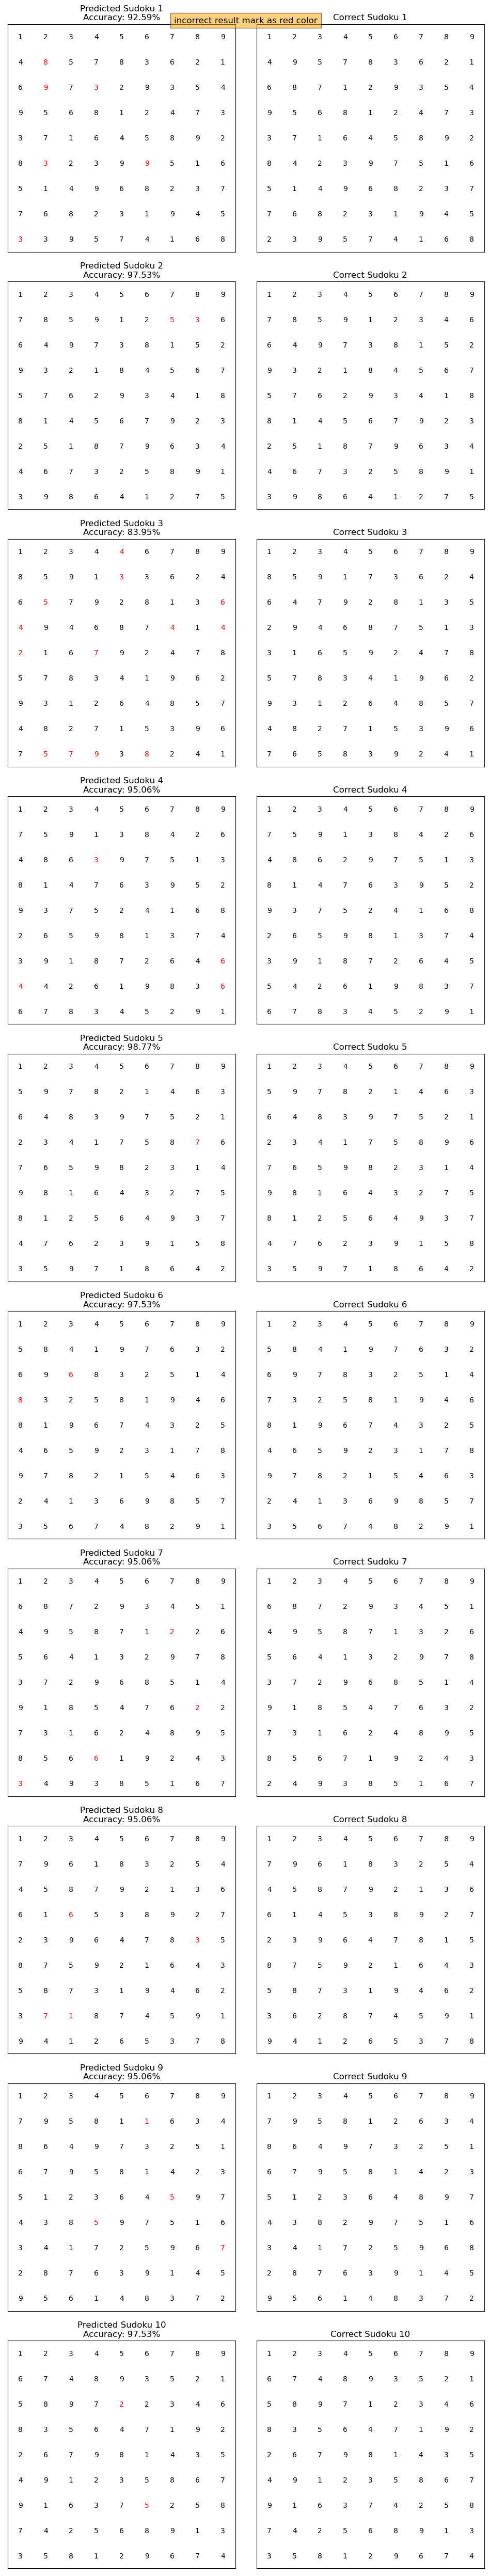

In [ ]:
def predict_and_display(model, device, test_loader, num_samples=10):
    model.eval()
    predictions = []
    targets = []

    with torch.set_grad_enabled(False):
        for i, data in enumerate(test_loader):
            if i >= num_samples:
                break

            sudoku = data[0].to(device)
            target = data[1].to(device)
            hint = data[2].to(device)

            input_data = torch.stack((sudoku, hint), dim=1).to(device)  # [batch_size, 2, 9, 9]

            # forward pass to get outputs
            output = model(input_data)
            preds = torch.argmax(output, dim=1)

            predictions.append(preds.cpu().numpy())
            targets.append(target.cpu().numpy())

    return predictions, targets

def plot_sudoku_grid(pred, target, title, ax):
    ax.matshow(np.zeros((9, 9)), cmap='Greys', vmin=0, vmax=1)
    for i in range(9):
        for j in range(9):
            if pred[i, j] != target[i, j]:
                ax.text(j, i, str(pred[i, j] + 1), va='center', ha='center', color='red')
            else:
                ax.text(j, i, str(pred[i, j] + 1), va='center', ha='center')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

def display_results(predictions, targets):
    fig, axes = plt.subplots(len(predictions), 2, figsize=(10, len(predictions) * 5))

    for i, (pred, target) in enumerate(zip(predictions, targets)):
        accuracy = (pred[0] == target[0]).mean()
        plot_sudoku_grid(pred[0], target[0], f"Predicted Sudoku {i + 1}\nAccuracy: {accuracy:.2%}", axes[i, 0])
        plot_sudoku_grid(target[0], target[0], f"Correct Sudoku {i + 1}", axes[i, 1])

    plt.tight_layout()
    plt.figtext(0.5, 0.99, "incorrect result mark as red color", ha="center", fontsize=12, bbox={"facecolor": "orange", "alpha": 0.5, "pad": 5})
    plt.show()

predictions, targets = predict_and_display(model, device, test_loader, num_samples=10)
display_results(predictions, targets)

## Method 5: Off-policy Monte Carlo

We put our code into our Github Repo. You can see the code in the link here:
https://github.com/DevinChen02/COGS188_GroupAAA_Project/blob/main/Monte_Carlo.ipynb

# Results

### Dynamic Programming (policy iteration)
1. **Results of with different parameters**:
   - optimal hyper-parameter is `gamma = 0.8`

2. **Randomized Sudoku Puzzle Test**:
   - 100 randomly selected killer Sudoku puzzles were tested and accuracy lies between 10% and 26%.

Our experimental results show that the DP algorithm performs poorly in solving the problem of killer sudoku.

### Dynamic Programming with Backtracking
**Our experiment shows that this algorithm is able to solve all selected killer sudoku puzzle, the solving time depends on the difficulty of the puzzle.**

Simpler puzzles (less constraints) takes <500 seconds, harder ones take >1000 seconds, but all 9*9 killer sudoku are solvable by this method.


### SARSA
1. **Results of parametric search**:
   - Optimal parameters: `alpha=0.15`, `gamma=0.2`, `epsilon=0.1`.

2. **Randomized Sudoku Puzzle Test**:
   - 10,000 randomly generated Sudoku puzzles were tested and the average accuracy of all puzzles was `15.06%`.

Our experimental results show that the SARSA algorithm performs poorly in solving the problem of killer sudoku

### CNN
Our CNN model's performance was monitored over 15 training cycles, and the testing loss and accuracy were recorded for each cycle. Surprisingly, the CNN model performed well overall, with a maximum accuracy of 99.70%.
The model showed continuous improvement in most training cycles, especially achieving nearly 100% accuracy in the 11th to 14th cycles. This indicates that the model successfully captured the features in the question, and I believe we were successful on this model. We uploaded the final model to GitHub together

### Off-policy Monte Carlo
1. **Results of with different parameters**:
   - optimal hyper-parameter is `gamma = 0.9`, `epsilon = 0.1`. The best accuracy is about 19%.

2. **Reward and accuracy over time**:
   - For 16 different combination of hyper-parameters, the agent performs badly, achieving accuracies lower than 20%. The plots show that the reward and accuracy did not have an increasing trend over 10000 episode.

# Discussion


## Interpreting the result


#### 1. Dynamic Programming (Policy Iteration)
1. **Main point: The Dynamic Programming (policy iteration) performs poorly on solving killer Sudoku puzzles**.
- The results show that the DP algorithm achieved accuracies from 10% to 24% on 100 randonly selected puzzles. We hypothesize that this might be due to the large state space the killer sudoku puzzle has (10^81). There might be a better way to set up the environment and the agent (re-define reward function, transitional function...) so that it may achieve better performances. However, DP might still perform badly due to the non-Markovian nature of killer sudoku.

2. **Secondary point: the best performed DP agent has the hyper-parameter gamma = 0.8, but still the highest accuracy it achieves is 0.26.**
- We used different hyper-parameters gamma to learn from 100 randomly selected puzzles. However, the accuracies each agent achieves are between 10% to 26%. This means that fine-tuning the hyper-parameters might not be the way to improve the DP model.

#### 2. Dynamic Programming + Backtracking
1. **Main point: Dynamic Programming with Backtracking is able to solve killer sudoku efficiently**.
- For each randomly selected killer sudoku puzzle, the algorithm is gauranteed to find a solution. Simple puzzles (puzzles with less/easy constraints) will take less time (< 500 seconds) to solve, while harder ones take longer (> 1000 seconds). But regardless of how long it takes, the agent can always solve the puzzle.

2. **Secondary point: DP + backtracking combines the strengths of DP and backtracking, which may be why this algorithm works so well.** Since killer sudoku can be broken down to multiple subproblems based on its row/column/box/cage constraints, we can use memorization from DP to store the solved subproblems to avoid redundant calculations. This way we reduced the time complexity. With backtracking, we make sure that the agent can perform recursive exploration so that it won't miss the optimal solution.

#### 3. SARSA
1. **Main point: The SARSA algorithm performs poorly on solving killer Sudoku puzzles**.
- Experimental results show that the SARSA algorithm has an average accuracy of only 15.06% on 10,000 randomly generated Sudoku puzzles. We conjecture that the reason for such poor results may be due to its large state-action space under complex constraints, which leads to inefficient learning. And since Killer Sudoku is not a standard MV environment, where the correctness of an outcome is not only affected by the current state and action but may be affected by the global state, SARSA is very ineffective when we do not find a careful, method of dealing with historical information.

2. **Secondary point: the parameter search found the optimal parameters to be `alpha=0.15`, `gamma=0.2`, `epsilon=0.1`**.
- Although we performed a parameter search and found a relatively optimal set of parameter combinations, this did not significantly improve the performance of the algorithm. This represents the possibility that the SARSA algorithm may be inherently unsuitable for solving killer sudoku problems, or for solving any problem that does not fit into the MV environment.

#### 4. CNN
1. Key takeaway: the CNN model performs well in solving Sudoku problems**.
- The CNN model shows significant performance improvement over 15 training cycles, with a test accuracy of up to 99.70%. This result shows that with proper data initialization, CNNs are able to extract the correct feature information and solve the problem through feature matching between answers and questions, even if the Sudoku problem itself is a logical inference problem.

2. Secondary observation: the model shows continuous improvement over most of the training cycles, and this continuous improvement suggests that the model gradually optimizes its weights during the training process and successfully captures the patterns and rules of Sudoku problems. We are pleased to see that the model is robust and reliable.

#### 5. Off-policy Monte Carlo
1. **Main point: The off-policy Monte Carlo method performs poorly on solving killer Sudoku puzzles**.
- The results show that the off-policy MC achieved accuracies lower than 20% on the randomly selected puzzle. Also, the agent doesn't seem to learn from the environment because the rewards and accuracies never converge nor have an increasing trend. This might be due to the fact that the environment is non-Markovian.

2. **Secondary point: the best performed off-policy MC agent has the hyper-parameter gamma = 0.9, epsilon = 0.1, but still the highest accuracy it achieves is only 0.19.**
- We used different hyper-parameters gamma and epsilon to learn from the randomly selected puzzles. However, the accuracies each agent achieves are between 0% to 25%. This means that fine-tuning the hyper-parameters might not be the way to improve the MC model.

## Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   

#### 1. Dynamic Programming (policy iteration)

**Reward function limitation**:
The reward function is defined in an intuitive way as if the agent is in a Markovian environment. However, the killer sudoku doesn't quite fall into the Markovian category; solving killer sudoku is more about putting the right numbers in the right cell following the constraints. So how to define the reward function may help the agent learn better, and this is something to explore.

#### 2. Dynamic Programming with backtracking

**Time efficiency limitation**:
Also this algorithm can solve the 9x9 killer sudoku puzzle efficienly, the worst time complexity of this algorithm is still large (O(n^(n^2))). So when the grid get larger, the algorithm might need more time to get the solution.

#### 3. SARSA

1. **Data Volume and Complexity Limitations**:
- In non-MV environments, the current state depends not only on current observations, but may also depend on historical sequences of observations.SARSA is an algorithm that learns based on state-action pairs, assuming that the environment is a Markov Decision Process (MDP), i.e., the future state is dependent only on the current state and the actions, and is independent of the history. In non-MV environments, it is difficult for SARSA to capture the historical dependence of states, leading to incomplete state representations and thus affecting the effectiveness of the policy.

- Also non-MV environments usually have a more complex state space because the state is not only determined by current observations but also includes historical information. This can lead to a dramatic expansion of the state space (and we have not edited a very fine-grained system to handle historical information), making it difficult for SARSA to efficiently explore and learn all possible state-action pairs within a limited training time. In addition, the increase in state space also makes the Q-value table sparse, which affects the learning efficiency and performance.

2. **Insufficient hyperparameter exploration**:
- This experiment only searched a limited number of parameter combinations and failed to comprehensively cover all possible hyperparameter spaces. And the number of our training set is still relatively small compared to such a complex problem (we only have twelve thousand data). The performance of SARSA may be improved if the hyperparameter combinations can be performed more carefully and the amount of data can be increased

3. **Balance between exploration and utilization**:
-Complexity in non-MV environments increases the difficulty of exploration, as the algorithm needs to find the optimal policy in a larger state space.SARSA's epsilon-greedy policy may not be sufficient for effective exploration in such cases, leading the algorithm to fall into local optima or fail to fully utilize experience for learning. To improve the efficiency of learning we may need to find a more efficient action selection strategy.

4. **Credit allocation problem**:
-In the killer Sudoku setting the result of the current action may be delayed until multiple future time steps before manifesting itself, e.g., a currently optimal action may be proved wrong after several steps.SARSA relies on immediate feedback from the current state-action pairs for updating, whereas in the non-MV setting, the feedback signals may be lagging behind, which may make it difficult for the algorithm to accurately evaluate the value of the action, which may then affect the strategy optimization.

#### 4. CNN

1. **Data Volume and Problem Complexity Limitations**:
- Although the CNN performs well under our processing, this good result is predicated on the fact that we have processed the topic to enhance the salience of the problem features. The CNN does not perform as well before the topic is analyzed without more detailed human weighting. This represents the fact that CNN still relies on feature saliency, which is clearly insufficient for the problem Killer Sudoku without tuning.

2. **Lack of data samples**:
- Compared to other neural network models for Sudoku problems that can be found on the internet we have too little data. These models usually require more than one million data to analyze while we only have twelve thousand. The lack of data volume could be the reason why the model could not capture the feature information without the help we provided. We made up for the lack of sample size with a higher number of training rounds, but in the end our model still didn't answer a Sudoku question 100% correctly, it still made mistakes.

### 5. Off-policy Monte Carlo
It didn't go through a thorough hyper-parameter search to find the optimal hyper-parameter. In addition, how to better set up the environment is critical for the agent to learn efficienly.


## Ethics & Privacy

This project is designed and implemented to adhere to strict ethical standards of data science to ensure that the data is processed legally and ethically, while protecting user privacy (which we won't actually cover) and data security.

### Data collection
- **Informed Consent**: we do not collect data directly from users and therefore do not require their informed consent. And because this project uses open source data, we hold a license to use that data.
- **Collection Bias**: The killer Sudoku dataset we use does not introduce gender, racial, or other social biases; it is purely and simply a math game.
- **Limitation of Personally Identifiable Information (PII) Exposure**: This project does not involve any personally identifiable information and is based entirely on impersonal data.

### Data Storage
- **DATA SECURITY**: All data used is stored on secure servers (colabs), necessary security measures are taken, and we limit sharing and reading/editing permissions on project links to ensure that the data is not subject to unauthorized access.
- **Data Retention Plan**: All data is deleted from the server immediately after the completion of the project without any form of persistent storage.

### Analyze
- **Honest Representation**: All data analysis and algorithm outputs will be presented in the most honest and transparent manner possible, and all visualizations will be based on rigorous mathematical conclusions. All conclusions and data representations we make in this project are accurate and have not been distorted or deliberately manipulated.

### Modeling
- **Explainability**: We will ensure the transparency and explainability of the model's decision-making process and provide detailed written text and diagrams of our model's principles so that readers can understand how the model works and the logic of the solution.

### Deployment
- **Unintended Use**: We will monitor all usage records of our model to ensure that it is not used by others without our authorization for purposes other than completing the project (e.g., at its simplest, academic plagiarism) to avoid violations.

## Conclusion

In this study, we evaluated various computational models for solving Killer Sudoku puzzles, including CNNs, backtracking search algorithms, SARSA, and Monte Carlo (MC) methods. We initially hypothesized that CNNs might underperform due to their focus on complex inter-data relationships, which are overly explicit in killer Sudoku puzzles. Conversely, we anticipated that the backtracking search algorithm would perform best due to its direct applicability to Sudoku's logical structure.

Our findings indicated that although CNNs performed slightly better than expected, they were not as effective as the backtracking algorithm in solving Sudoku challenges. The backtracking search algorithm proved to be the most effective model, consistently solving puzzles of varying difficulty, thereby confirming our assumptions about its suitability.

On the other hand, the SARSA and MC methods did not perform as well as expected due to the complexity and non-Markovian nature of Killer Sudoku. Despite incorporating relevant state and action spaces, these models struggled with efficiently learning and utilizing relationships between state-action pairs. We initially believed that with proper tuning, these methods might become viable; however, they require further optimization and a more effective strategy for handling historical data and complex state transitions.

Future work should focus on enhancing the efficiency of the SARSA and MC algorithms by optimizing state representations and reward functions and exploring more sophisticated methods to manage the complexity inherent in Killer Sudoku. Additionally, expanding the dataset size and exploring a broader range of hyperparameters may enable these models to better capture and utilize necessary relationships, thus solving complex problems more effectively. The success of the backtracking algorithm also suggests potential for further refinements to increase efficiency and handle more complex Sudoku variants.

This research underscores the importance of selecting the right computational approach based on the characteristics of the problem and highlights the potential for hybrid models that combine the strengths of different computational techniques to more effectively tackle complex, structured problems.

# Footnotes
1. <a name="killernote">Fonseca, Jose B, "A Novel MILP Model to Solve Killer Samurai Sudoku Puzzles."</a>

2. <a name="thesisnote">Rajwardhan Kumar, "Algorithm Selection using Machine Learning for Sudoku Puzzles." Master's thesis, 2021. computer science, mathematics.</a>

3. <a name="sotonote">Ricardo Soto et al., "A Hybrid alldifferent-Tabu Search Algorithm for Solving Sudoku Puzzles." publish at "Computational Intelligence…",May 20, 2015 . Computer Science, Math.</a>
